In [8]:
import cmdstanpy, arviz
from abc import ABC, abstractmethod, abstractproperty
from typing import Optional
from cmdstanpy import CmdStanModel
from typing import Optional
from enum import Enum
from dataclasses import dataclass
from arviz import InferenceData

class FitType(Enum):
    OPTIMIZE = 0
    SAMPLE = 1

class StanModel(ABC):
    
    def __init__(self, **kwargs):
        self.model = CmdStanModel(stan_file=self.stan_file)
        self.init_params = kwargs
        
    @abstractproperty
    def stan_file(self): 
        raise NotImplementedError
        
    @abstractmethod
    def construct_model_data(self, data: pd.DataFrame):
        raise NotImplementedError
        
    def _validate_data(self):
        self.data_class(**self.model_data)

    def fit(
        self, 
        data: pd.DataFrame,
        fit_type: FitType = FitType.SAMPLE,
        map_initialization: bool = True,
        save_dir: Optional[str] = None,
        verbose: bool = True,
        **kwargs
    ) -> InferenceData:
        self.model_data = self.construct_model_data(data)
        
        self._validate_data()
        
        self.fit_type = fit_type
        
        if fit_type == FitType.SAMPLE:
            if verbose:
                print("Fitting model by sampling...")
            
            if map_initialization:
                print("Initializing sampling at MAP...")
                init_model = self.__class__(**self.init_params)
                init_model.fit(data, fit_type=FitType.OPTIMIZE, verbose=False)
                map_estimate = init_model.raw_model_fit.stan_variables()
                
                if "inits" in kwargs:
                     # inits passed to fit() should override MAP
                    map_estimate.update(kwargs["inits"])
                    
                kwargs["inits"] = map_estimate
            
            self.raw_model_fit = self.model.sample(
                data=self.model_data,
                **kwargs
            )
        else:
            if verbose:
                print("Fitting model by optimizing...")
            
            self.raw_model_fit = self.model.optimize(
                data=self.model_data,
                **kwargs
            )
            
    
        if save_dir is not None:
            if verbose:
                print("Saving model...")

            self.save(save_dir)
    
        return self
    
    @property
    def model_fit(self):
        if self.fit_type == FitType.SAMPLE:
            return arviz.from_cmdstanpy(
                self.raw_model_fit, 
                coords=self.coords if hasattr(self, "coords") else {},
                dims=self.dims if hasattr(self, "dims") else {}
            )
        else:
            return self.raw_model_fit
    
    def save(self, save_dir: str = "."):
        self.raw_model_fit.save_csvfiles(save_dir)
    
    @classmethod
    def from_csv(cls, path: str, **kwargs):
        model = cls(**kwargs)
        model.raw_model_fit = cmdstanpy.from_csv(path)

In [10]:
from numpy import ndarray
from pandas import CategoricalDtype

def hash_series(series: pd.Series, categories: Optional[list[str]] = None, indexation: int=1) -> tuple[ndarray, ndarray]:
    """Hash a series to numeric codes
    
    Parameters
    ----------
    column
        The series to hash
    index
        The starting index (defaults to 1)
    """
    # enforce 0- or 1-indexation
    if indexation not in [0, 1]:
        raise ValueError("Must choose either 0- or 1-indexation.")
    
    # convert the series to a category
    if categories is None:
        category_series = series.astype("category")
    else:
        cat_type = CategoricalDtype(categories=categories)
        category_series = series.astype(cat_type)
    
    # get the hash
    hash_map = category_series.cat.categories.values
    
    # map to one-indexed codes
    hashed_series = (category_series.cat.codes + indexation).values
    
    return hash_map, hashed_series

In [11]:
from scipy.stats import norm

@dataclass
class NormingData:
    N_resp: int                  # number of responses
    N_context: int               # number of contexts
    N_subj: int                  # number of subjects
    context: ndarray             # context corresponding to response n
    subj: ndarray                # subject who gave response n
    resp: ndarray                # likert scale acceptability judgment responses

class NormingModel(StanModel):
    stan_file = norming_model_path
    data_class = NormingData
    
    def __init__(self):
        super().__init__()
    
    def construct_context_info(self, data: pd.DataFrame):
        self.context_info = data[["item", "prompt", "fact"]].drop_duplicates(ignore_index=True)
        self.context_info = self.context_info.rename(columns={"item": "context"})
    
    def construct_model_data(self, data: pd.DataFrame):
        self.construct_context_info(data)
        
        if hasattr(self, "subj_hash_map"):
            _, subj_hashed = hash_series(data.workerid, self.subj_hash_map)
        else:
            self.subj_hash_map, subj_hashed = hash_series(data.workerid)
            
        if hasattr(self, "context_hash_map"):
            _, context_hashed = hash_series(data.item, self.context_hash_map)
        else:
            self.context_hash_map, context_hashed = hash_series(data.item)
        
        self.coords = {
            "subj": self.subj_hash_map,
            "context": self.context_hash_map
        }
        
        self.dims = {
            "context_intercept": ["context"],
            "context_prob": ["context"],
        }
        
        self.model_data = {
            "N_resp": data.shape[0],
            "N_context": self.context_hash_map.shape[0],
            "N_subj": self.subj_hash_map.shape[0],
            "context": context_hashed,
            "subj": subj_hashed,
            "resp": data.response.astype(float).values
        }
        
        return self.model_data
    
    @property
    def context_posterior_estimates(self):
        if self.fit_type == FitType.SAMPLE:
            context_intercept_samples = self.raw_model_fit.stan_variable("context_intercept")
            
            params = []
            
            for i in range(context_intercept_samples.shape[1]):
                mu, sigma = norm.fit(context_intercept_samples[:,i])
                context = self.context_hash_map[i]
                params.append([context, mu, sigma])

            params_df = pd.DataFrame(params, columns=["context", "context_mean", "context_std"])
            params_df["order"] = params_df.index
            params_df = pd.merge(params_df, self.context_info).sort_values("order")
            
            return params_df[["fact", "context", "prompt", "context_mean", "context_std", "order"]]
        else:
            raise NotImplementedError

In [12]:
norming_model = NormingModel().fit(
    data_norming, map_initialization=False, 
    iter_warmup=2_000, iter_sampling=2_000, seed=40392
)

16:57:41 - cmdstanpy - INFO - CmdStan start processing


Fitting model by sampling...


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

16:58:20 - cmdstanpy - INFO - CmdStan done processing.
16:58:20 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/home/jovyan/work/projective-content/models/norming-model/norming-model.stan', line 40, column 2 to column 55)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/home/jovyan/work/projective-content/models/norming-model/norming-model.stan', line 43, column 2 to column 49)
Consider re-running with show_console=True if the above output is unclear!


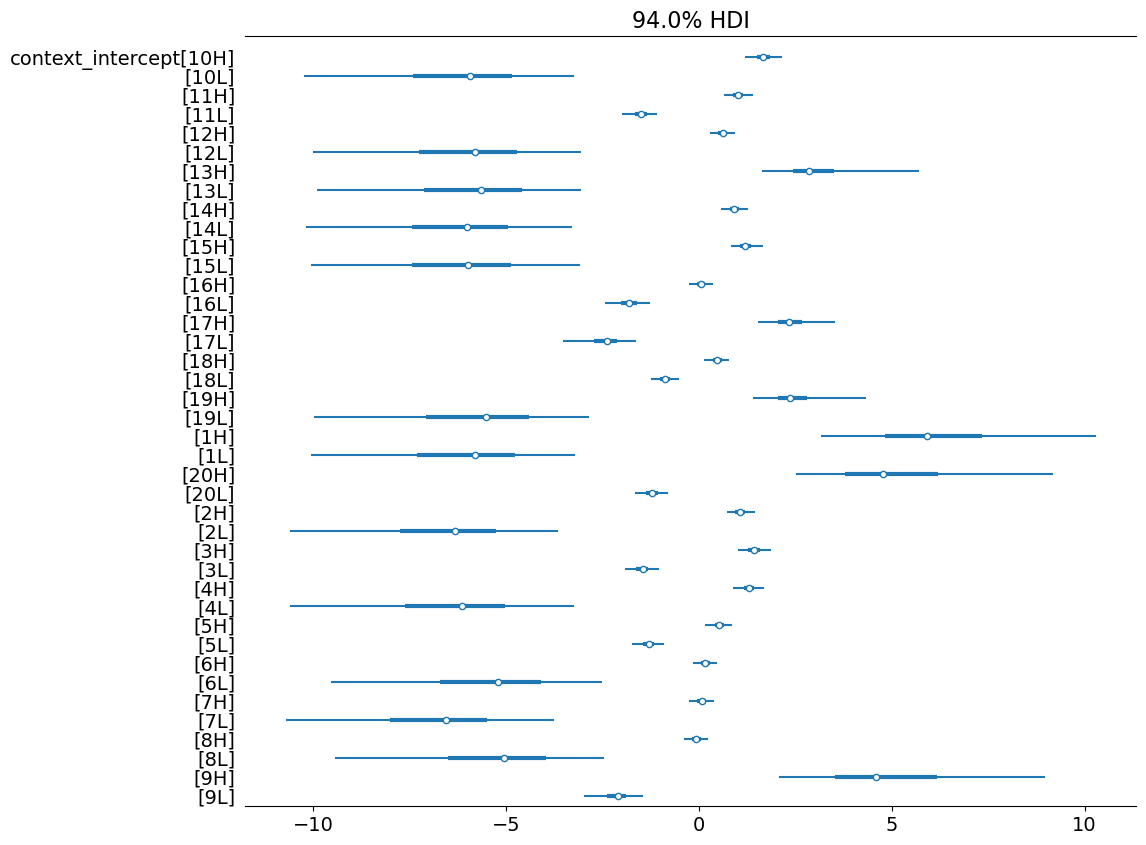

In [13]:
_ = arviz.plot_forest(
    norming_model.model_fit,
    var_names=["context_intercept"],
    combined=True,
    figsize=(11.5, 10)
)

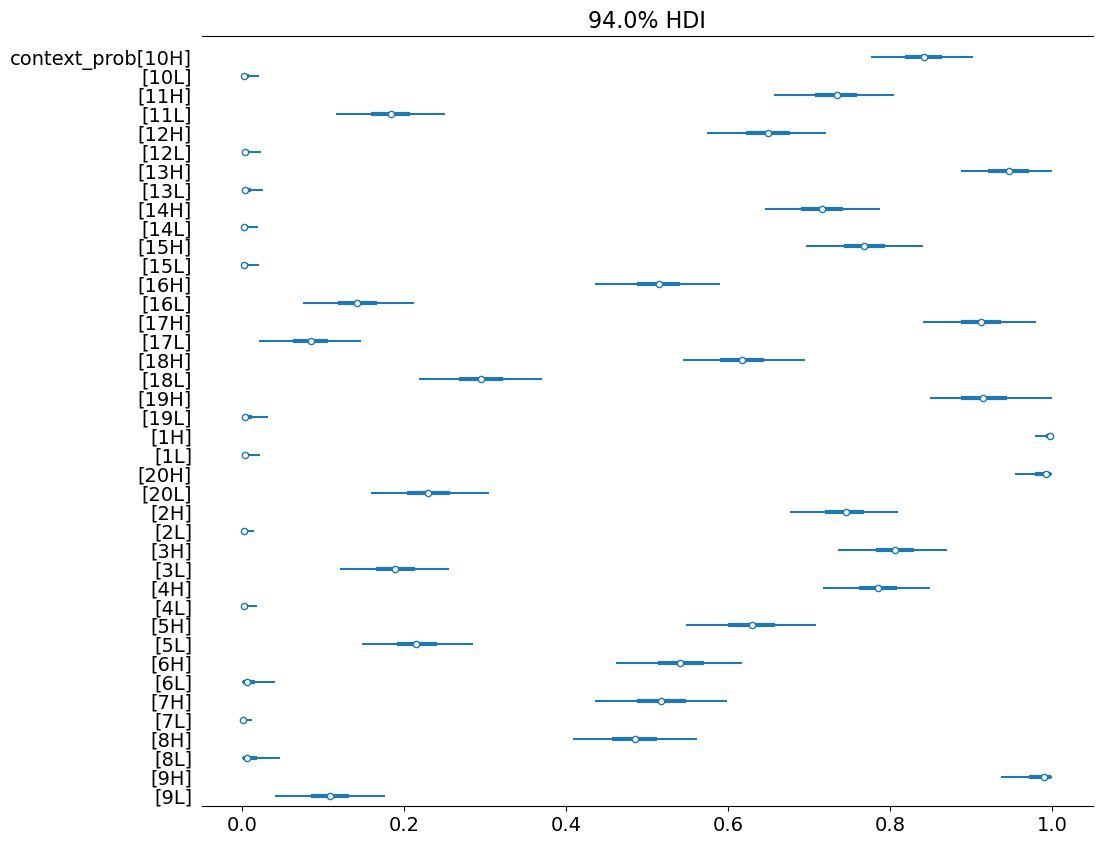

In [14]:
_ = arviz.plot_forest(
    norming_model.model_fit,
    var_names=["context_prob"],
    combined=True,
    figsize=(11.5, 10)
)

In [15]:
samples = pd.DataFrame(
    norming_model.raw_model_fit.stan_variable("context_intercept"),
    columns=norming_model.context_hash_map
)

samples = pd.merge(pd.melt(samples, var_name="context"), norming_model.context_info)
samples["itemType"] = samples.context.map(lambda x: x[-1])

samples_sub = samples.query('context.isin(["10H", "10L"])')

samples_sub

,context,value,prompt,fact,itemType
0,10H,1.86212,How likely is it that Zoe calculated the tip?,Zoe is a math major.,H
1,10H,1.73999,How likely is it that Zoe calculated the tip?,Zoe is a math major.,H
2,10H,1.38718,How likely is it that Zoe calculated the tip?,Zoe is a math major.,H
3,10H,1.73442,How likely is it that Zoe calculated the tip?,Zoe is a math major.,H
4,10H,1.86627,How likely is it that Zoe calculated the tip?,Zoe is a math major.,H
...,...,...,...,...,...
15995,10L,-6.97041,How likely is it that Zoe calculated the tip?,Zoe is 5 years old.,L
15996,10L,-4.89358,How likely is it that Zoe calculated the tip?,Zoe is 5 years old.,L
15997,10L,-6.17656,How likely is it that Zoe calculated the tip?,Zoe is 5 years old.,L
15998,10L,-4.68528,How likely is it that Zoe calculated the tip?,Zoe is 5 years old.,L


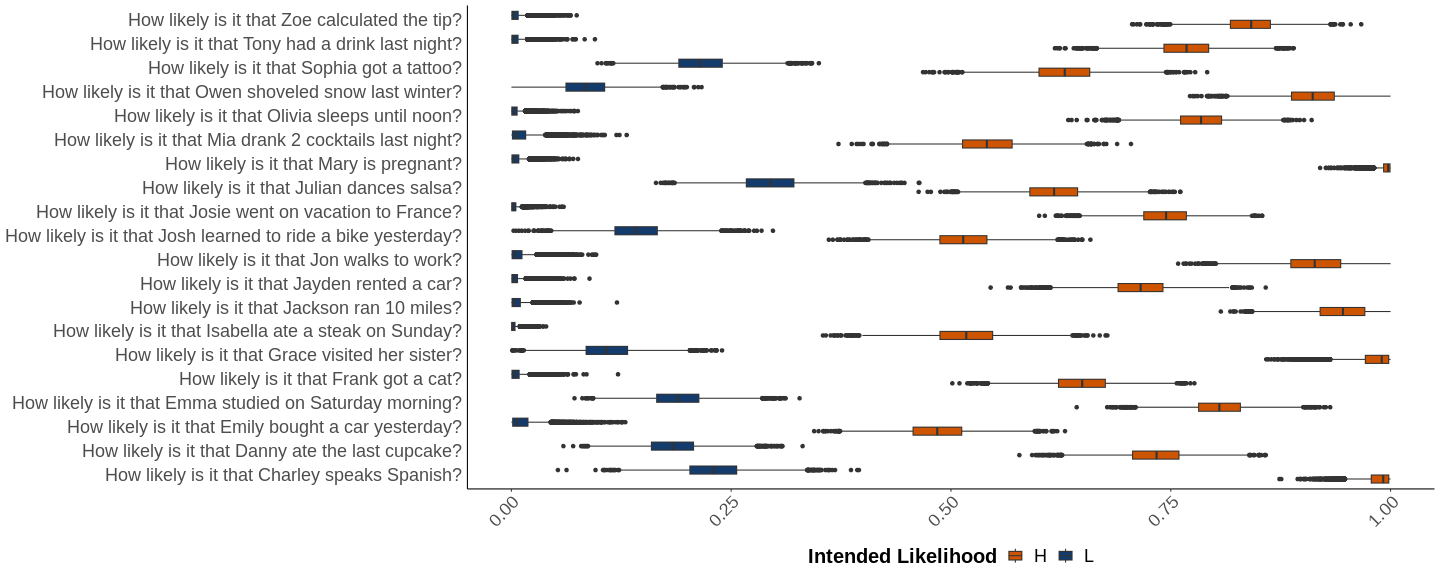

In [16]:
%%R -i samples -w 20 -h 8 -u in

p <- ggplot(samples, aes(x=prompt, y=plogis(value), fill=itemType)) + 
geom_boxplot() +
coord_flip() +
scale_fill_manual(name="Intended Likelihood", values=c("#CD5400", "#133B6C")) +
theme(axis.title.x=element_blank(),
      axis.title.y=element_blank(),
      axis.text=element_text(size=18),
      axis.text.x=element_text(angle=45, hjust=1),
      axis.ticks.y=element_blank(),
      legend.title=element_text(size=20, face="bold"),
      legend.text=element_text(size=18),
      legend.position="bottom")

ggsave("norming-posterior-distributions.png", width=20, height=8)

p

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


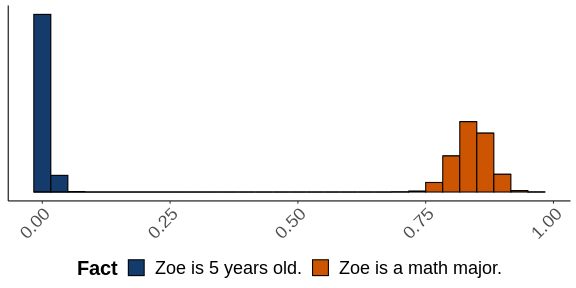

In [17]:
%%R -i samples_sub -w 8 -h 4 -u in

p <- ggplot(samples_sub, aes(x=plogis(value), fill=fact)) +
geom_histogram(color="black") +
scale_fill_manual(name="Fact", values=c("#133B6C", "#CD5400")) +
theme(axis.title.x=element_blank(),
      axis.title.y=element_blank(),
      axis.text.y=element_blank(),
      axis.text=element_text(size=18),
      axis.text.x=element_text(angle=45, hjust=1),
      axis.ticks.y=element_blank(),
      legend.title=element_text(size=20, face="bold"),
      legend.text=element_text(size=18),
      legend.position="bottom")

ggsave("norming-posterior-example.png", width=8, height=4)

p

In [18]:
context_posterior_estimates = norming_model.context_posterior_estimates

context_posterior_estimates = context_posterior_estimates.set_index("context")

context_posterior_estimates

,fact,prompt,context_mean,context_std,order
context,,,,,
10H,Zoe is a math major.,How likely is it that Zoe calculated the tip?,1.682417,0.260563,0
10L,Zoe is 5 years old.,How likely is it that Zoe calculated the tip?,-6.355352,2.062079,1
11H,Danny loves cake.,How likely is it that Danny ate the last cupcake?,1.018309,0.203021,2
11L,Danny is a diabetic.,How likely is it that Danny ate the last cupcake?,-1.509393,0.244486,3
12H,Frank has always wanted a pet.,How likely is it that Frank got a cat?,0.616739,0.173204,4
12L,Frank is allergic to cats.,How likely is it that Frank got a cat?,-6.199000,2.069092,5
13H,Jackson is training for a marathon.,How likely is it that Jackson ran 10 miles?,3.245416,1.387925,6
13L,Jackson is obese.,How likely is it that Jackson ran 10 miles?,-6.059125,2.052598,7
14H,Jayden&quotechars car is in the shop.,How likely is it that Jayden rented a car?,0.927931,0.187294,8


In [19]:
import seaborn as sns
import matplotlib.pyplot as plt
from numpy import mgrid
from scipy.special import expit, logit
from statsmodels.distributions.empirical_distribution import ECDF

def plot_context_intercept_posterior(context_id: str, axis="unit", plot_diff: bool=True):
    context_estimates = context_posterior_estimates.loc[context_id]
    
    estimated_dist = norm(context_estimates.context_mean, context_estimates.context_std)
    
    samples = norming_model.raw_model_fit.stan_variable("context_intercept")[:,context_estimates.order]
    
    if axis == "unit":
        x_axis = mgrid[0.01:1:0.01]
        
        samples = expit(samples)
        
        ecdf = sns.ecdfplot(samples)
        
        plt.plot(x_axis, estimated_dist.cdf(logit(x_axis)))
    
        if plot_diff:
            plt.plot(mgrid[0.01:1:0.01], ECDF(samples)(x_axis) - estimated_dist.cdf(logit(x_axis)))
        
    elif axis=="reals":
        x_axis = mgrid[samples.min():samples.max():0.01]
                 
        ecdf = sns.ecdfplot(samples)
        
        plt.plot(x_axis, estimated_dist.cdf(x_axis))
        
        if plot_diff:
            plt.plot(x_axis, ECDF(samples)(x_axis) - estimated_dist.cdf(x_axis))
        
    else:
        raise ValueError("'axis' must be \"unit\" or \"reals\".")

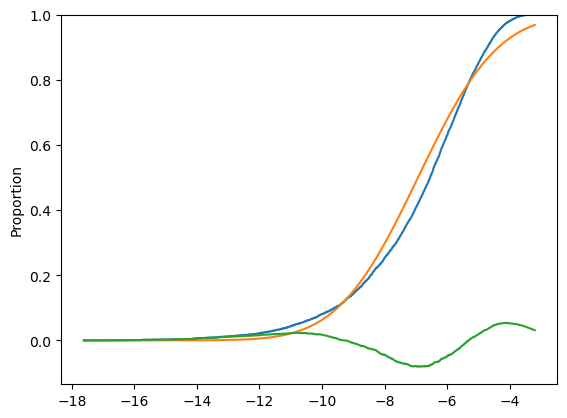

In [20]:
plot_context_intercept_posterior("7L", axis="reals")

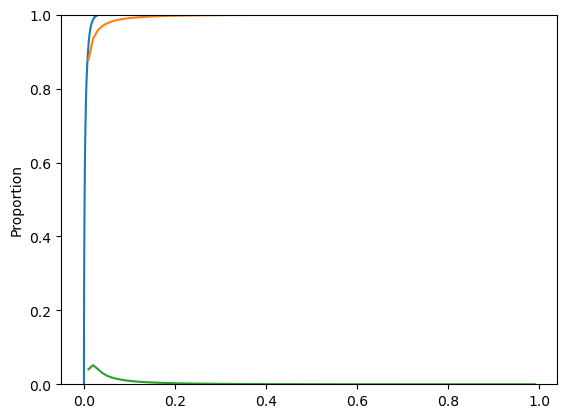

In [21]:
plot_context_intercept_posterior("7L", axis="unit")

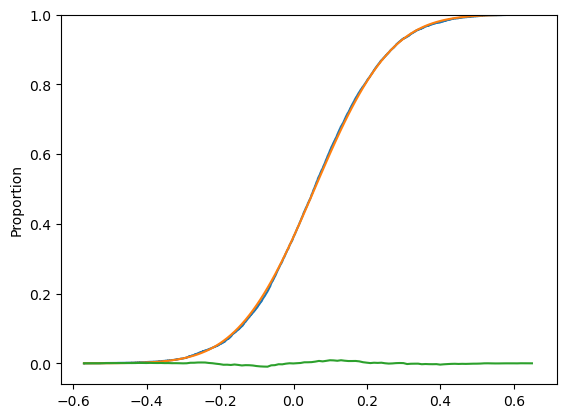

In [22]:
plot_context_intercept_posterior("16H", axis="reals")

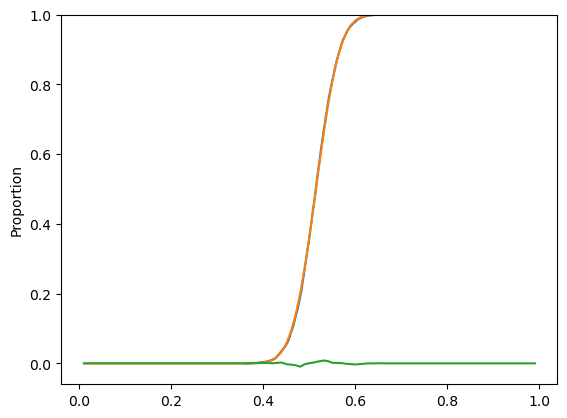

In [23]:
plot_context_intercept_posterior("16H", axis="unit")

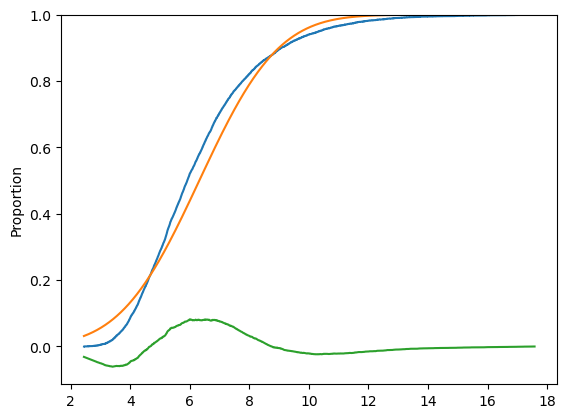

In [24]:
plot_context_intercept_posterior("1H", axis="reals")

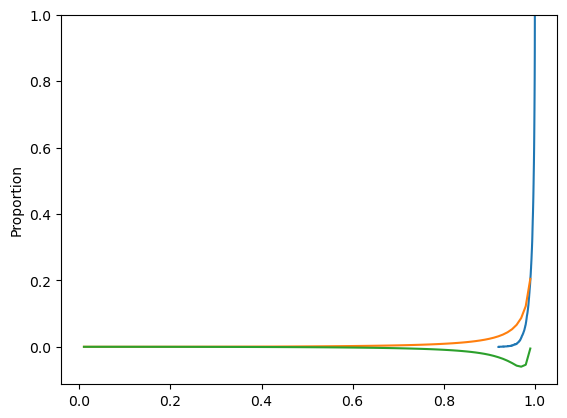

In [25]:
plot_context_intercept_posterior("1H", axis="unit")

In [29]:
from numpy import zeros, ones

@dataclass
class ProjectionData(NormingData):
    N_verb: int                           # number of verbs
    verb: ndarray                         # verb corresponding to response n
    verb_mean: ndarray                    # the verb means inferred from a previous model fit
    verb_std: ndarray                     # the verb standard deviations inferred from a previous model fit
    context_mean: ndarray                 # the context means inferred from the norming data
    context_std: ndarray                  # the context standard deviations inferred from the norming data

In [36]:
from typing import Union

class ProjectionModel(StanModel):
    stan_data_block_file = projection_model_stan_data_block_file
    stan_generated_quantities_block_file = projection_model_stan_generated_quantities_file
    
    data_class = ProjectionData
    
    def __init__(self, prior_model: Optional[Union[NormingModel, 'ProjectionModel']] = None, use_context_prior: bool = True):
        self.prior_model = prior_model
        
        self.use_context_priors = use_context_prior and prior_model is not None
        self.use_verb_priors = hasattr(
            prior_model, "verb_posterior_estimates"
        )
        
        if self.use_context_priors and self.use_verb_priors:
            print("Model initialized with context- and verb-specific priors derived "
                  "from context- and verb-specific posteriors from prior_model.")
            self.context_hash_map = prior_model.context_hash_map
            self.verb_hash_map = prior_model.verb_hash_map
            
            self.stan_parameters_and_model_block_file = os.path.join(
                model_dir, 
                "projection-model/parameters-and-model-block/", 
                parameters_and_model_block_files["both_priors_fixed"]
            )
        
        elif self.use_context_priors:
            print("Model initialized with context-specific priors derived "
                  "from context-specific posteriors from prior_model.")
            self.context_hash_map = prior_model.context_hash_map
            
            self.stan_parameters_and_model_block_file = os.path.join(
                model_dir, 
                "projection-model/parameters-and-model-block/", 
                parameters_and_model_block_files["context_priors_fixed"]
            )
        
        elif self.use_verb_priors:
            print("Model initialized with verb-specific priors derived "
                  "from verb-specific posteriors from prior_model.")
            self.verb_hash_map = prior_model.verb_hash_map
            
            self.stan_parameters_and_model_block_file = os.path.join(
                model_dir, 
                "projection-model/parameters-and-model-block/", 
                parameters_and_model_block_files["verb_priors_fixed"]
            )
            
        else:
            self.stan_parameters_and_model_block_file = os.path.join(
                model_dir, 
                "projection-model/parameters-and-model-block/", 
                parameters_and_model_block_files["no_priors_fixed"]
            )
            
        self._write_stan_file()
            
        super().__init__()
    
    def _write_stan_file(self):
        functions_block = open(self.stan_functions_block_file, "r").read()
        data_block = open(self.stan_data_block_file, "r").read()
        parameters_and_model_block = open(self.stan_parameters_and_model_block_file, "r").read()
        generated_quantities_block = open(self.stan_generated_quantities_block_file, "r").read()
        
        print(f"Writing STAN file to {self.stan_file}...")
        
        with open(self.stan_file, "w") as f:
            f.write(functions_block+"\n\n")
            f.write(data_block+"\n\n")
            f.write(parameters_and_model_block+"\n\n")
            f.write(generated_quantities_block)
    
    @abstractproperty
    def stan_functions_block_file(self):
        raise NotImplementedError
    
    def construct_context_info(self, data: pd.DataFrame):
        if hasattr(self.prior_model, "context_info"):
            self.context_info = self.prior_model.context_info
        else:
            data["prompt"] = data["content"]
            NormingModel.construct_context_info(self, data)
    
    def construct_model_data(self, data: pd.DataFrame):
        self.model_data = NormingModel.construct_model_data(self, data)
        
        if hasattr(self, "verb_hash_map"):
            _, verb_hashed = hash_series(data.verb, self.verb_hash_map)
        else:
            self.verb_hash_map, verb_hashed = hash_series(data.verb)
        
        self.coords.update({
            "verb": self.verb_hash_map
        })
        
        self.dims.update({
            "verb_intercept": ["verb"],
            "verb_prob": ["verb"]
        })
        
        self.model_data.update({
            "N_verb": self.verb_hash_map.shape[0],
            "verb": verb_hashed
        })
        
        if self.use_context_priors:
            self.model_data.update({
                "context_mean": self.context_prior_estimates.context_mean.values,
                "context_std": self.context_prior_estimates.context_std.values
            })
        else:
            self.model_data.update({
                "context_mean": zeros(self.model_data["N_context"]),
                "context_std": ones(self.model_data["N_context"]),
            })
        
        if self.use_verb_priors:
            self.model_data.update({
                "verb_mean": self.verb_prior_estimates.verb_mean.values,
                "verb_std": self.verb_prior_estimates.verb_std.values,
            })
        else:
            self.model_data.update({
                "verb_mean": zeros(self.model_data["N_verb"]),
                "verb_std": ones(self.model_data["N_verb"]),
            })

        return self.model_data
        
    @property
    def context_prior_estimates(self):
        if self.use_context_priors:
            return self.prior_model.context_posterior_estimates
        else:
            raise AttributeError("no prior_model supplied for context priors")
    
    @property
    def context_posterior_estimates(self):
        if self.fit_type == FitType.SAMPLE:
            context_intercept_samples = self.raw_model_fit.stan_variable("context_intercept")
            
            params = []
            
            for i in range(context_intercept_samples.shape[1]):
                mu, sigma = norm.fit(context_intercept_samples[:,i])
                context = self.context_hash_map[i]
                params.append([context, mu, sigma])

            params_df = pd.DataFrame(params, columns=["context", "context_mean", "context_std"])
            params_df["order"] = params_df.index
            params_df = pd.merge(params_df, self.context_info).sort_values("order")
            
            return params_df[["fact", "context", "prompt", "context_mean", "context_std", "order"]]
        else:
            raise NotImplementedError
            
    @property
    def verb_prior_estimates(self):
        if self.use_verb_priors:
            return self.prior_model.verb_posterior_estimates
        else:
            raise AttributeError("prior_model must have verb_posterior_estimates")
            
    @property
    def verb_posterior_estimates(self):
        if self.fit_type == FitType.SAMPLE:
            verb_intercept_samples = self.raw_model_fit.stan_variable("verb_intercept")
            
            params = []
            
            for i in range(verb_intercept_samples.shape[1]):
                mu, sigma = norm.fit(verb_intercept_samples[:,i])
                verb = self.verb_hash_map[i]
                params.append([verb, mu, sigma])

            params_df = pd.DataFrame(params, columns=["verb", "verb_mean", "verb_std"])
            params_df["order"] = params_df.index
            
            return params_df
        else:
            raise NotImplementedError

$$\begin{align*} &c ∼ \texttt{JDS}
&p ∼ \texttt{knowsJDS} \ &τₚ ∼ \texttt{Bernoulli}(p) \ &η ( τ_c ∼ \texttt{Bernoulli}(c); η(τₚ ∨ τ_c) ) \end{align*}$$

In [37]:
class FullyDiscreteProjectionModel(ProjectionModel):
    stan_functions_block_file = os.path.join(
        model_dir, "projection-model/fully-discrete/fully-discrete-likelihoods.stan"
    )
    stan_file = os.path.join(
        model_dir, "projection-model/fully-discrete/fully-discrete-model.stan"
    )

In [38]:
fully_discrete_projection_model = FullyDiscreteProjectionModel(norming_model)
fully_discrete_projection_model.fit(
    data_projection, iter_warmup=2_000, iter_sampling=2_000, seed=40392
)

16:58:32 - cmdstanpy - INFO - compiling stan file /home/jovyan/work/projective-content/models/projection-model/fully-discrete/fully-discrete-model.stan to exe file /home/jovyan/work/projective-content/models/projection-model/fully-discrete/fully-discrete-model


Model initialized with context-specific priors derived from context-specific posteriors from prior_model.
Writing STAN file to models/projection-model/fully-discrete/fully-discrete-model.stan...


16:58:45 - cmdstanpy - INFO - compiled model executable: /home/jovyan/work/projective-content/models/projection-model/fully-discrete/fully-discrete-model
16:58:45 - cmdstanpy - WARNING - Stan compiler has produced 3 warnings:
16:58:45 - cmdstanpy - WARNING - 
--- Translating Stan model to C++ code ---
bin/stanc  --o=/home/jovyan/work/projective-content/models/projection-model/fully-discrete/fully-discrete-model.hpp /home/jovyan/work/projective-content/models/projection-model/fully-discrete/fully-discrete-model.stan
Warning in '/home/jovyan/work/projective-content/models/projection-model/fully-discrete/fully-discrete-model.stan', line 29, column 2: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.33.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
Warning in '/home/jovyan/work/projective-content/models/projection-model/fully-discrete/fully-dis

Fitting model by sampling...
Initializing sampling at MAP...
Writing STAN file to models/projection-model/fully-discrete/fully-discrete-model.stan...


16:58:57 - cmdstanpy - INFO - compiled model executable: /home/jovyan/work/projective-content/models/projection-model/fully-discrete/fully-discrete-model
16:58:57 - cmdstanpy - WARNING - Stan compiler has produced 3 warnings:
16:58:57 - cmdstanpy - WARNING - 
--- Translating Stan model to C++ code ---
bin/stanc  --o=/home/jovyan/work/projective-content/models/projection-model/fully-discrete/fully-discrete-model.hpp /home/jovyan/work/projective-content/models/projection-model/fully-discrete/fully-discrete-model.stan
Warning in '/home/jovyan/work/projective-content/models/projection-model/fully-discrete/fully-discrete-model.stan', line 29, column 2: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.33.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
Warning in '/home/jovyan/work/projective-content/models/projection-model/fully-discrete/fully-dis

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

17:04:35 - cmdstanpy - INFO - CmdStan done processing.


In [39]:
print(fully_discrete_projection_model.raw_model_fit.diagnose())

Processing csv files: /tmp/tmp_c0tivx9/fully-discrete-modelnkibo_je/fully-discrete-model-20230528165858_1.csv, /tmp/tmp_c0tivx9/fully-discrete-modelnkibo_je/fully-discrete-model-20230528165858_2.csv, /tmp/tmp_c0tivx9/fully-discrete-modelnkibo_je/fully-discrete-model-20230528165858_3.csv, /tmp/tmp_c0tivx9/fully-discrete-modelnkibo_je/fully-discrete-model-20230528165858_4.csv

Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
No divergent transitions found.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory.

Effective sample size satisfactory.

Split R-hat values satisfactory all parameters.

Processing complete, no problems detected.



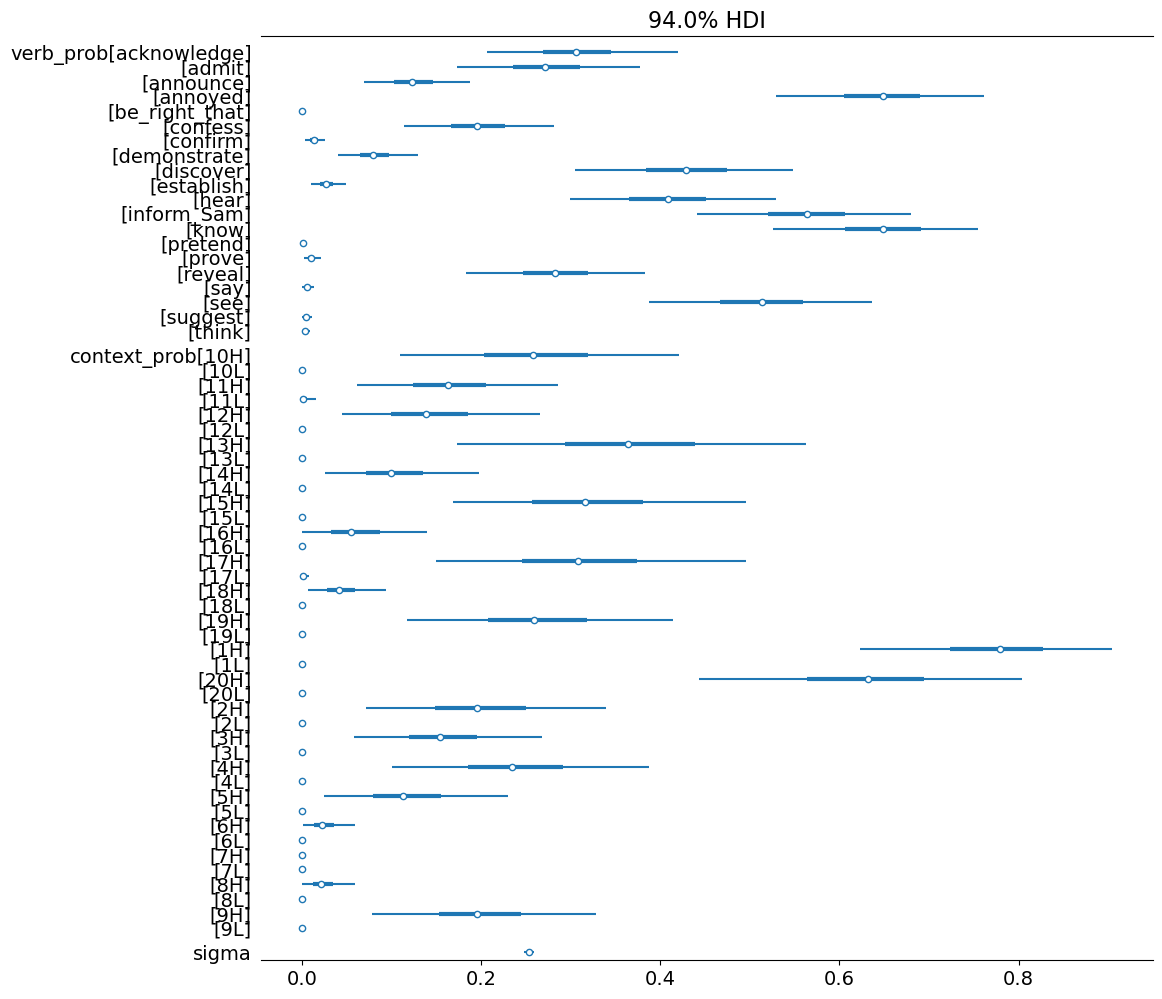

In [40]:
_ = arviz.plot_forest(
    fully_discrete_projection_model.model_fit,
    var_names=["verb_prob", "context_prob", "sigma"],
    combined=True,
    figsize=(11.5, 12),
)

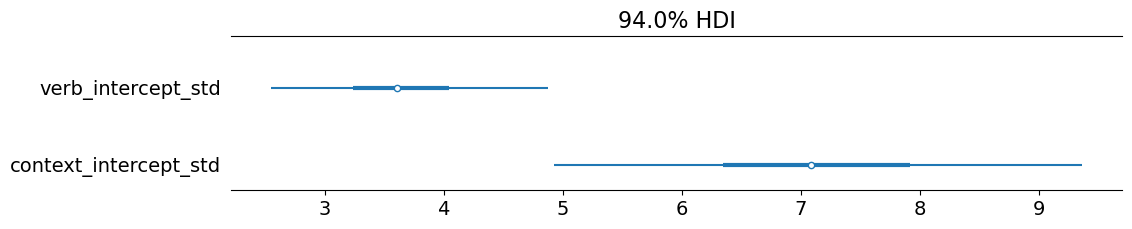

In [41]:
_ = arviz.plot_forest(
    fully_discrete_projection_model.model_fit,
    var_names=["verb_intercept_std", "context_intercept_std"],
    combined=True,
    figsize=(11.5, 2),
)

In [42]:
import rpy2
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [43]:
%%R -i data_projection

head(data_projection)

  workerid   rt subjectGender speakerGender                          content
3        0 3495             M             M     Emily bought a car yesterday
4        0 3866             F             M                  Frank got a cat
5        0 2983             F             F           Charley speaks Spanish
6        0 4669             F             F                Jon walks to work
7        0 3847             M             F Mia drank 2 cocktails last night
8        0 3052             F             F              Julian dances salsa
           verb                              fact fact_type contentNr
3     establish  Emily has been saving for a year     factH         8
4         prove     Frank has always wanted a pet     factH        12
5        reveal           Charley lives in Mexico     factH        20
6       confirm Jon lives 10 miles away from work     factL        19
7   acknowledge          Mia is a college student     factH         6
8 be_right_that                   Julian 

/opt/conda/lib/python3.10/site-packages/rpy2/robjects/pandas2ri.py:65: UserWarning: Error while trying to convert the column "comments". Fall back to string conversion. The error is: Series can only be of one type, or None (and here we have <class 'float'> and <class 'str'>). If happening with a pandas DataFrame the method infer_objects() will normalize data types before conversion.
  warnings.warn('Error while trying to convert '


In [44]:
verb_discrete_model_functions_block = os.path.join(
    model_dir, "projection-model/verb-discrete/verb-discrete-likelihoods.stan"
)

with open(verb_discrete_model_functions_block, "r") as f:
    display(HTML(highlight(f.read(), StanLexer(), HtmlFormatter())))

In [45]:
class VerbDiscreteProjectionModel(ProjectionModel):
    stan_functions_block_file = os.path.join(
        model_dir, "projection-model/verb-discrete/verb-discrete-likelihoods.stan"
    )
    stan_file = os.path.join(
        model_dir, "projection-model/verb-discrete/verb-discrete-model.stan"
    )

In [46]:
verb_discrete_projection_model = VerbDiscreteProjectionModel(norming_model)
verb_discrete_projection_model.fit(
    data_projection, iter_warmup=2_000, iter_sampling=2_000, seed=40392
)

17:06:25 - cmdstanpy - INFO - compiling stan file /home/jovyan/work/projective-content/models/projection-model/verb-discrete/verb-discrete-model.stan to exe file /home/jovyan/work/projective-content/models/projection-model/verb-discrete/verb-discrete-model


Model initialized with context-specific priors derived from context-specific posteriors from prior_model.
Writing STAN file to models/projection-model/verb-discrete/verb-discrete-model.stan...


17:06:37 - cmdstanpy - INFO - compiled model executable: /home/jovyan/work/projective-content/models/projection-model/verb-discrete/verb-discrete-model
17:06:37 - cmdstanpy - WARNING - Stan compiler has produced 3 warnings:
17:06:37 - cmdstanpy - WARNING - 
--- Translating Stan model to C++ code ---
bin/stanc  --o=/home/jovyan/work/projective-content/models/projection-model/verb-discrete/verb-discrete-model.hpp /home/jovyan/work/projective-content/models/projection-model/verb-discrete/verb-discrete-model.stan
Warning in '/home/jovyan/work/projective-content/models/projection-model/verb-discrete/verb-discrete-model.stan', line 25, column 2: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.33.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
Warning in '/home/jovyan/work/projective-content/models/projection-model/verb-discrete/verb-discrete-mode

Fitting model by sampling...
Initializing sampling at MAP...
Writing STAN file to models/projection-model/verb-discrete/verb-discrete-model.stan...


17:06:48 - cmdstanpy - INFO - compiled model executable: /home/jovyan/work/projective-content/models/projection-model/verb-discrete/verb-discrete-model
17:06:48 - cmdstanpy - WARNING - Stan compiler has produced 3 warnings:
17:06:48 - cmdstanpy - WARNING - 
--- Translating Stan model to C++ code ---
bin/stanc  --o=/home/jovyan/work/projective-content/models/projection-model/verb-discrete/verb-discrete-model.hpp /home/jovyan/work/projective-content/models/projection-model/verb-discrete/verb-discrete-model.stan
Warning in '/home/jovyan/work/projective-content/models/projection-model/verb-discrete/verb-discrete-model.stan', line 25, column 2: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.33.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
Warning in '/home/jovyan/work/projective-content/models/projection-model/verb-discrete/verb-discrete-mode

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

17:15:33 - cmdstanpy - INFO - CmdStan done processing.


In [47]:
print(verb_discrete_projection_model.raw_model_fit.diagnose())

Processing csv files: /tmp/tmp_c0tivx9/verb-discrete-modelq074ppst/verb-discrete-model-20230528170648_1.csv, /tmp/tmp_c0tivx9/verb-discrete-modelq074ppst/verb-discrete-model-20230528170648_2.csv, /tmp/tmp_c0tivx9/verb-discrete-modelq074ppst/verb-discrete-model-20230528170648_3.csv, /tmp/tmp_c0tivx9/verb-discrete-modelq074ppst/verb-discrete-model-20230528170648_4.csv

Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
No divergent transitions found.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory.

Effective sample size satisfactory.

The following parameters had split R-hat greater than 1.05:
  log_lik[1762], log_lik[1766], verb_prob_by_resp[1761], verb_prob_by_resp[1764], verb_prob_by_resp[1772], verb_prob_by_resp[1776], context_prob_by_resp[1762], context_prob_by_resp[1765], context_prob_by_resp[1766], context_prob_by_resp[1769], context_prob_by_resp[1771], context_prob_by

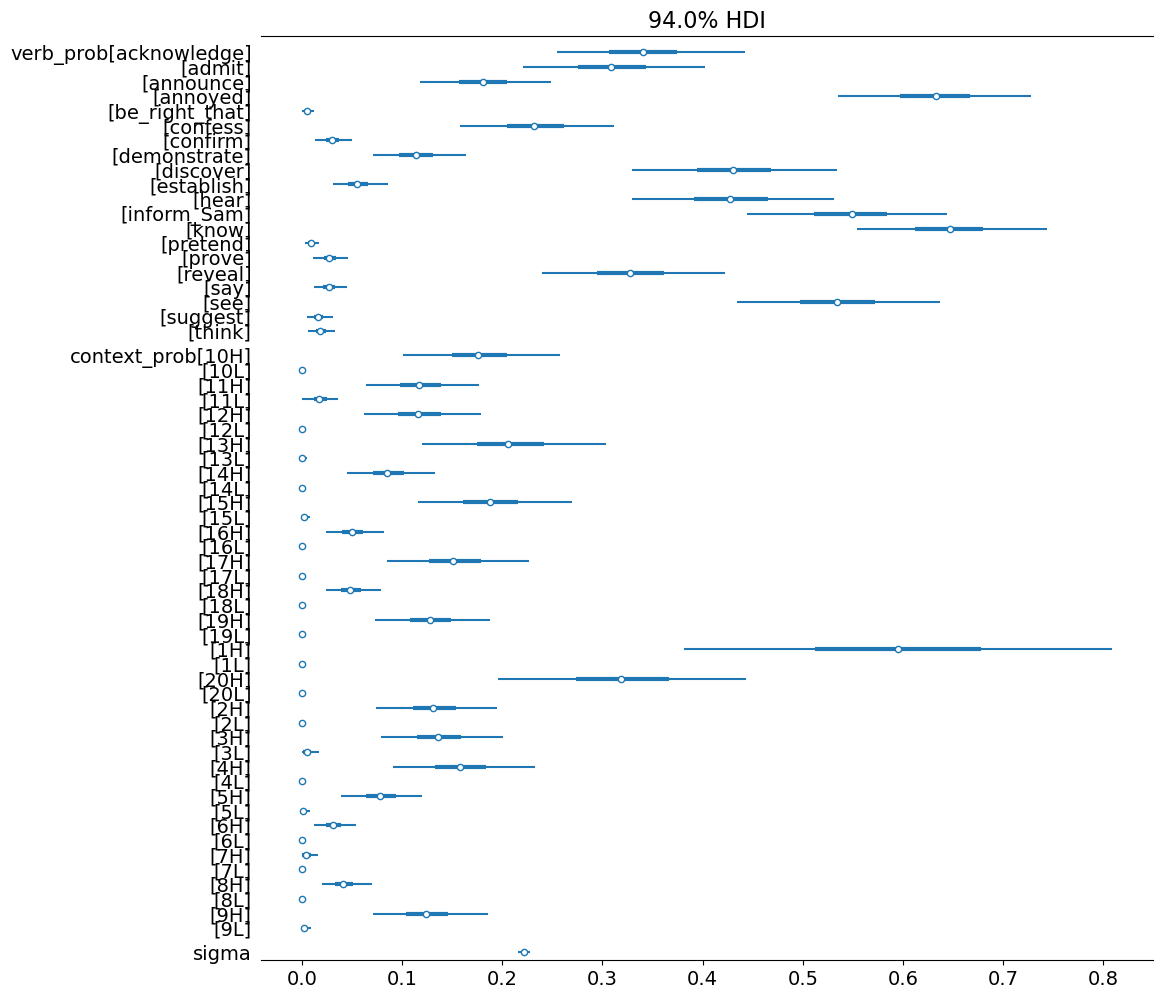

In [48]:
_ = arviz.plot_forest(
    verb_discrete_projection_model.model_fit,
    var_names=["verb_prob", "context_prob", "sigma"],
    combined=True,
    figsize=(11.5, 12),
)

In [50]:
context_discrete_model_noncentered_path = os.path.join(
    model_dir, "projection-model/context-discrete/context-discrete-likelihoods.stan"
)

with open(context_discrete_model_noncentered_path, "r") as f:
    display(HTML(highlight(f.read(), StanLexer(), HtmlFormatter())))

In [51]:
class ContextDiscreteProjectionModel(ProjectionModel):
    stan_functions_block_file = os.path.join(
        model_dir, "projection-model/context-discrete/context-discrete-likelihoods.stan"
    )
    stan_file = os.path.join(
        model_dir, "projection-model/context-discrete/context-discrete-model.stan"
    )

In [54]:
context_discrete_projection_model = ContextDiscreteProjectionModel(norming_model)
context_discrete_projection_model.fit(
    data_projection, iter_warmup=2_000, iter_sampling=2_000, seed=40392
)

17:21:47 - cmdstanpy - INFO - compiling stan file /home/jovyan/work/projective-content/models/projection-model/context-discrete/context-discrete-model.stan to exe file /home/jovyan/work/projective-content/models/projection-model/context-discrete/context-discrete-model


Model initialized with context-specific priors derived from context-specific posteriors from prior_model.
Writing STAN file to models/projection-model/context-discrete/context-discrete-model.stan...


17:21:58 - cmdstanpy - INFO - compiled model executable: /home/jovyan/work/projective-content/models/projection-model/context-discrete/context-discrete-model
17:21:58 - cmdstanpy - WARNING - Stan compiler has produced 3 warnings:
17:21:58 - cmdstanpy - WARNING - 
--- Translating Stan model to C++ code ---
bin/stanc  --o=/home/jovyan/work/projective-content/models/projection-model/context-discrete/context-discrete-model.hpp /home/jovyan/work/projective-content/models/projection-model/context-discrete/context-discrete-model.stan
Warning in '/home/jovyan/work/projective-content/models/projection-model/context-discrete/context-discrete-model.stan', line 25, column 2: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.33.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
Warning in '/home/jovyan/work/projective-content/models/projection-model/context-

Fitting model by sampling...
Initializing sampling at MAP...
Writing STAN file to models/projection-model/context-discrete/context-discrete-model.stan...


17:22:10 - cmdstanpy - INFO - compiled model executable: /home/jovyan/work/projective-content/models/projection-model/context-discrete/context-discrete-model
17:22:10 - cmdstanpy - WARNING - Stan compiler has produced 3 warnings:
17:22:10 - cmdstanpy - WARNING - 
--- Translating Stan model to C++ code ---
bin/stanc  --o=/home/jovyan/work/projective-content/models/projection-model/context-discrete/context-discrete-model.hpp /home/jovyan/work/projective-content/models/projection-model/context-discrete/context-discrete-model.stan
Warning in '/home/jovyan/work/projective-content/models/projection-model/context-discrete/context-discrete-model.stan', line 25, column 2: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.33.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
Warning in '/home/jovyan/work/projective-content/models/projection-model/context-

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

17:40:00 - cmdstanpy - INFO - CmdStan done processing.


In [55]:
print(context_discrete_projection_model.raw_model_fit.diagnose())

Processing csv files: /tmp/tmp_c0tivx9/context-discrete-modela8ccfpxw/context-discrete-model-20230528172210_1.csv, /tmp/tmp_c0tivx9/context-discrete-modela8ccfpxw/context-discrete-model-20230528172210_2.csv, /tmp/tmp_c0tivx9/context-discrete-modela8ccfpxw/context-discrete-model-20230528172210_3.csv, /tmp/tmp_c0tivx9/context-discrete-modela8ccfpxw/context-discrete-model-20230528172210_4.csv

Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
No divergent transitions found.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory.

The following parameters had fewer than 0.001 effective draws per transition:
  subj_intercept_verb_z[66], subj_intercept_verb_z[153], subj_intercept_context_z[66], subj_intercept_context_z[153], subj_intercept_verb[66], subj_intercept_verb[153], subj_intercept_context[66], subj_intercept_context[153], log_lik[1301], log_lik[1302], log_lik[1303], log_lik[130

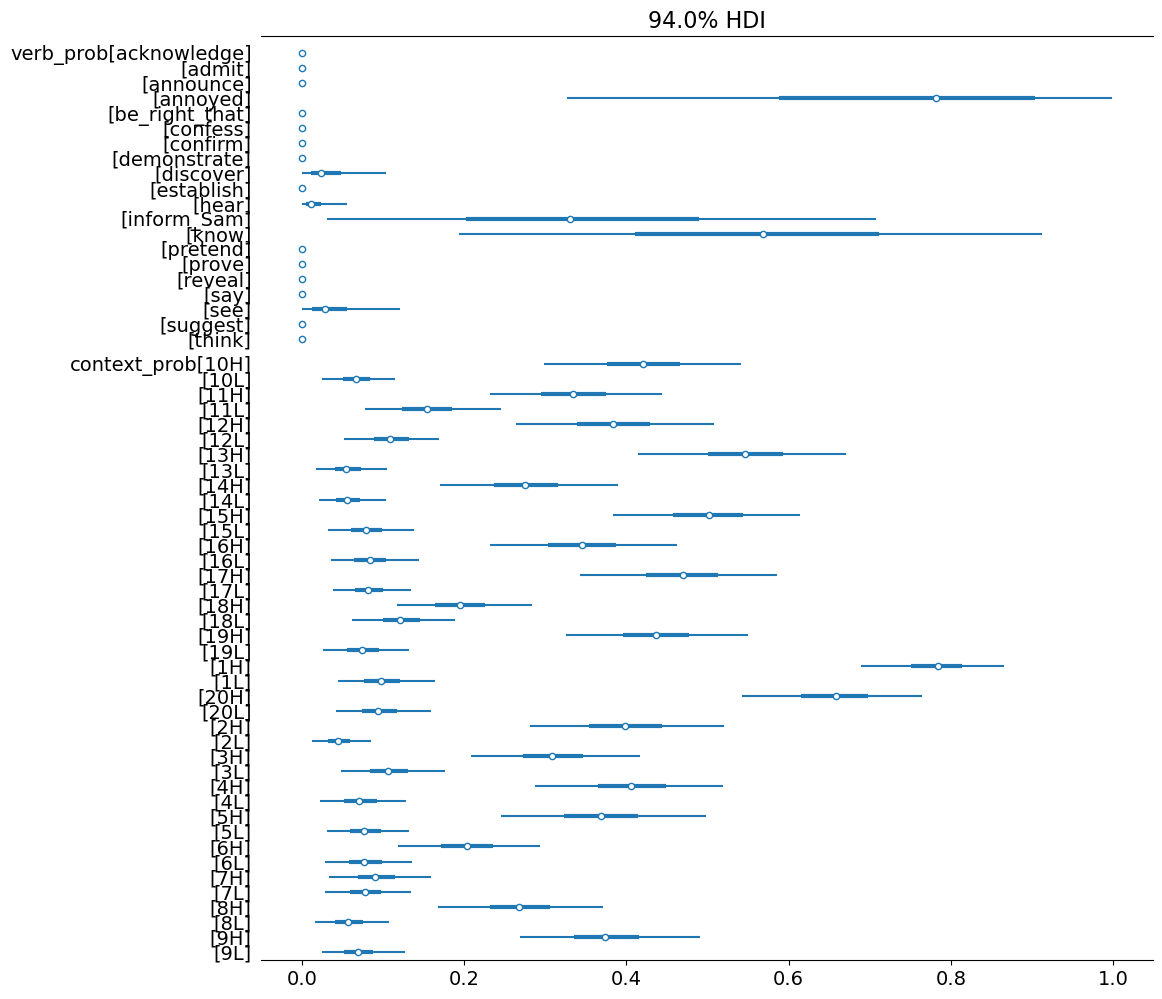

In [56]:
_ = arviz.plot_forest(
    context_discrete_projection_model.model_fit,
    var_names=["verb_prob", "context_prob"],
    combined=True,
    figsize=(11.5, 12),
)

$$\begin{align*} &c ∼ \texttt{JDS}
&p ∼ \texttt{knowsJDS} \ &η ( τₚ ∼ \texttt{Bernoulli}(p); τ_c ∼ \texttt{Bernoulli}(c); η(τₚ ∨ τ_c) ) \end{align*}$$

In [57]:
fully_gradient_model_noncentered_path = os.path.join(
    model_dir, "projection-model/fully-gradient/fully-gradient-likelihoods.stan"
)

with open(fully_gradient_model_noncentered_path, "r") as f:
    display(HTML(highlight(f.read(), StanLexer(), HtmlFormatter())))

In [58]:
class FullyGradientProjectionModel(ProjectionModel):
    stan_functions_block_file = os.path.join(
        model_dir, "projection-model/fully-gradient/fully-gradient-likelihoods.stan"
    )
    stan_file = os.path.join(
        model_dir, "projection-model/fully-gradient/fully-gradient-model.stan"
    )

In [59]:
fully_gradient_projection_model = FullyGradientProjectionModel(norming_model)
fully_gradient_projection_model.fit(
    data_projection, iter_warmup=2_000, iter_sampling=2_000, seed=40392
)

17:41:48 - cmdstanpy - INFO - compiling stan file /home/jovyan/work/projective-content/models/projection-model/fully-gradient/fully-gradient-model.stan to exe file /home/jovyan/work/projective-content/models/projection-model/fully-gradient/fully-gradient-model


Model initialized with context-specific priors derived from context-specific posteriors from prior_model.
Writing STAN file to models/projection-model/fully-gradient/fully-gradient-model.stan...


17:42:00 - cmdstanpy - INFO - compiled model executable: /home/jovyan/work/projective-content/models/projection-model/fully-gradient/fully-gradient-model
17:42:00 - cmdstanpy - WARNING - Stan compiler has produced 3 warnings:
17:42:00 - cmdstanpy - WARNING - 
--- Translating Stan model to C++ code ---
bin/stanc  --o=/home/jovyan/work/projective-content/models/projection-model/fully-gradient/fully-gradient-model.hpp /home/jovyan/work/projective-content/models/projection-model/fully-gradient/fully-gradient-model.stan
Warning in '/home/jovyan/work/projective-content/models/projection-model/fully-gradient/fully-gradient-model.stan', line 25, column 2: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.33.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
Warning in '/home/jovyan/work/projective-content/models/projection-model/fully-gradient/fully-gra

Fitting model by sampling...
Initializing sampling at MAP...
Writing STAN file to models/projection-model/fully-gradient/fully-gradient-model.stan...


17:42:11 - cmdstanpy - INFO - compiled model executable: /home/jovyan/work/projective-content/models/projection-model/fully-gradient/fully-gradient-model
17:42:11 - cmdstanpy - WARNING - Stan compiler has produced 3 warnings:
17:42:11 - cmdstanpy - WARNING - 
--- Translating Stan model to C++ code ---
bin/stanc  --o=/home/jovyan/work/projective-content/models/projection-model/fully-gradient/fully-gradient-model.hpp /home/jovyan/work/projective-content/models/projection-model/fully-gradient/fully-gradient-model.stan
Warning in '/home/jovyan/work/projective-content/models/projection-model/fully-gradient/fully-gradient-model.stan', line 25, column 2: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.33.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
Warning in '/home/jovyan/work/projective-content/models/projection-model/fully-gradient/fully-gra

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

17:52:38 - cmdstanpy - INFO - CmdStan done processing.


In [60]:
print(fully_gradient_projection_model.raw_model_fit.diagnose())

Processing csv files: /tmp/tmp_c0tivx9/fully-gradient-modelkg0d35x0/fully-gradient-model-20230528174212_1.csv, /tmp/tmp_c0tivx9/fully-gradient-modelkg0d35x0/fully-gradient-model-20230528174212_2.csv, /tmp/tmp_c0tivx9/fully-gradient-modelkg0d35x0/fully-gradient-model-20230528174212_3.csv, /tmp/tmp_c0tivx9/fully-gradient-modelkg0d35x0/fully-gradient-model-20230528174212_4.csv

Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
No divergent transitions found.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory.

The following parameters had fewer than 0.001 effective draws per transition:
  subj_intercept_verb_z[66], subj_intercept_verb_z[169], subj_intercept_context_z[169], subj_intercept_verb[66], subj_intercept_verb[169], subj_intercept_context[169], log_lik[1301], log_lik[1302], log_lik[1303], log_lik[1304], log_lik[1305], log_lik[1309], log_lik[1311], log_lik[1315], log_lik[13

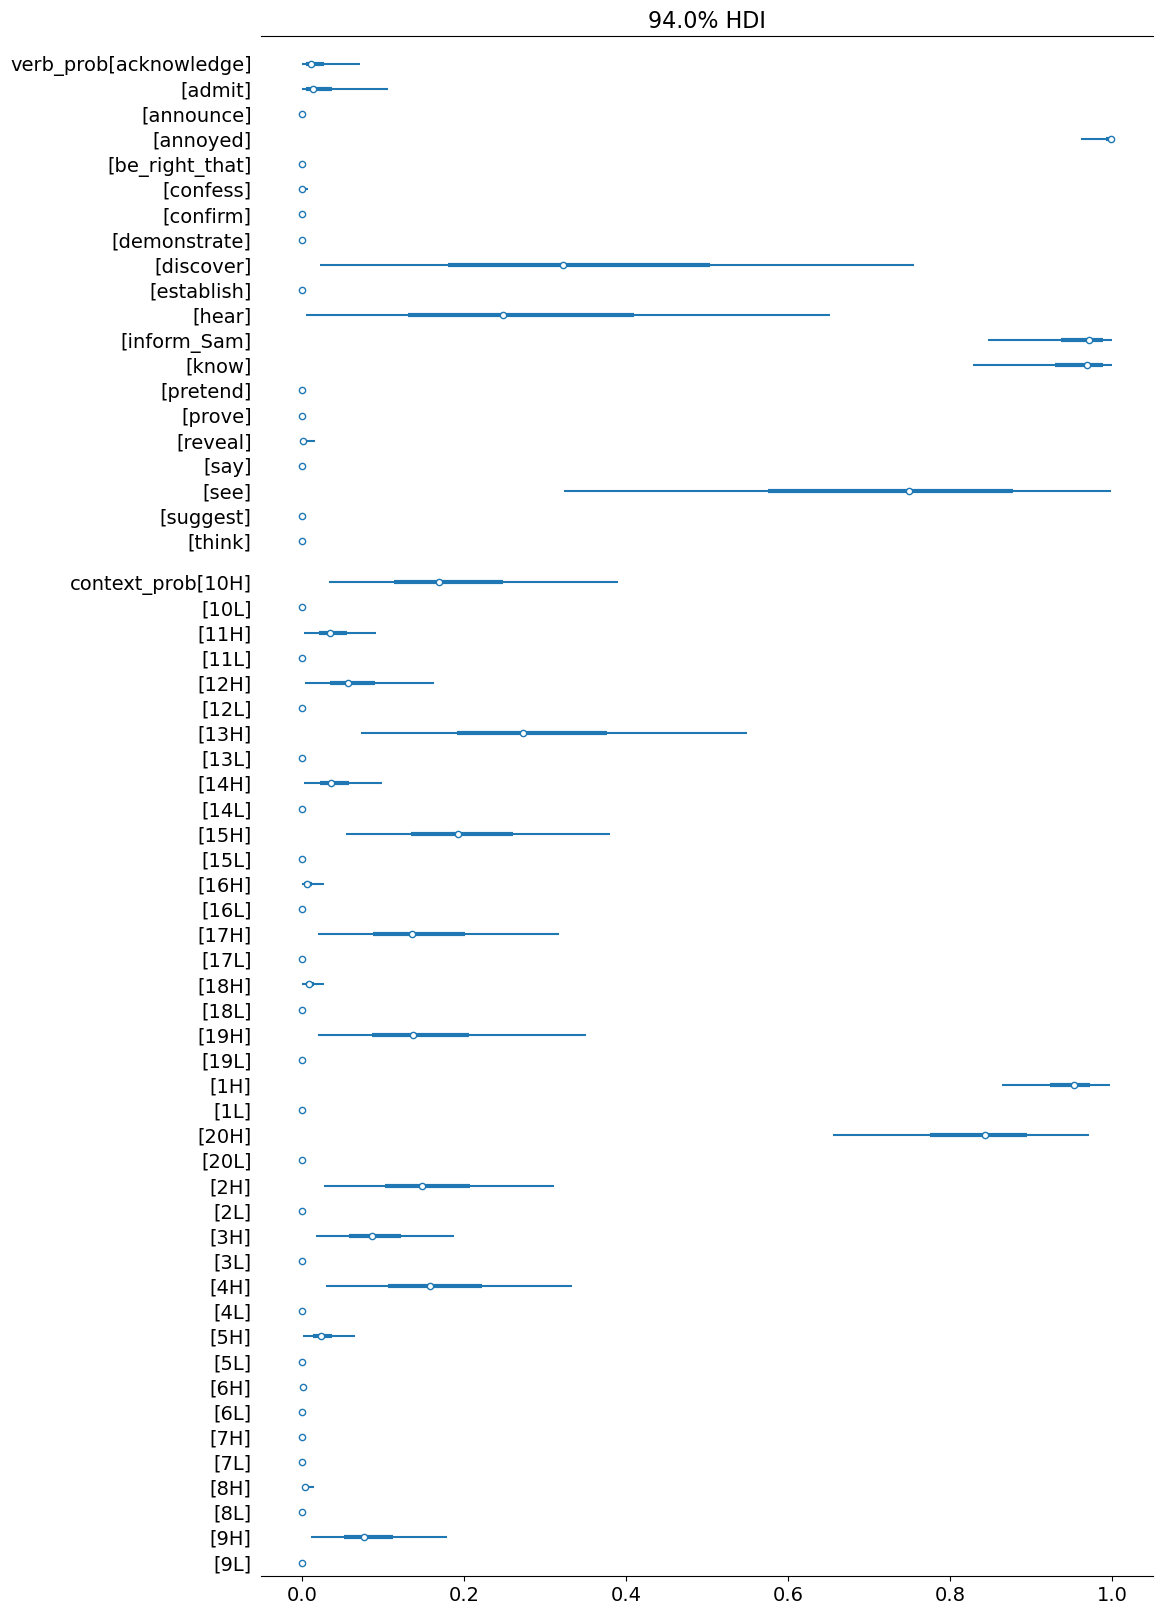

In [61]:
_ = arviz.plot_forest(
    fully_gradient_projection_model.model_fit,
    var_names=["verb_prob", "context_prob"],
    combined=True,
    figsize=(11.5, 20),
)

In [140]:
models = {
    "Verb Discrete\nContext Discrete": fully_discrete_projection_model,
    "Verb Discrete\nContext Gradient": verb_discrete_projection_model,
    "Verb Gradient\nContext Discrete": context_discrete_projection_model,
    "Verb Gradient\nContext Gradient": fully_gradient_projection_model
}

projection_model_comparison = arviz.compare({
    m_name: m.model_fit for m_name, m in models.items()
}).reset_index()

projection_model_comparison

,index,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
0,Verb Discrete\nContext Gradient,0,1977.388962,529.493419,0.000000,0.731178,62.782740,0.000000,True,log
1,Verb Discrete\nContext Discrete,1,1851.768019,391.267807,125.620943,0.028103,56.395583,30.519611,True,log
2,Verb Gradient\nContext Discrete,2,1475.988699,692.865615,501.400263,0.167403,61.242926,49.677178,True,log
3,Verb Gradient\nContext Gradient,3,1324.466786,886.750483,652.922176,0.073316,63.066930,52.694271,True,log


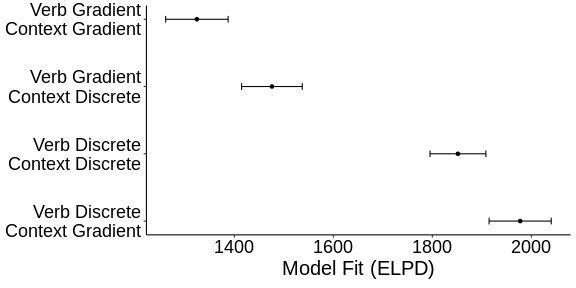

In [63]:
%%R -i projection_model_comparison -w 8 -h 4 -u in

p <- ggplot(projection_model_comparison, aes(x=rank, y=elpd_loo, ymin=elpd_loo-se, ymax=elpd_loo+se)) +
geom_errorbar(width=0.1) +
geom_point() +
scale_x_continuous(labels=projection_model_comparison$index) +
coord_flip() +
ylab(expression("Model Fit (ELPD)")) +
theme(axis.title.y=element_blank(),
      axis.title.x=element_text(size=20, face="bold"),
      axis.text=element_text(size=18, color="black"))

ggsave("projection_model_comparison.png", width=8, height=4)

p

In [142]:
verb_probs = []
 
for m_name, m in models.items():
    verb_probs_sub = pd.DataFrame(
        m.raw_model_fit.stan_variable("verb_prob"),
        columns=m.verb_hash_map
    )
    
    verb_probs_sub["model"] = m_name
    
    verb_probs.append(verb_probs_sub)
    
verb_probs = pd.concat(verb_probs)

verb_probs = pd.melt(verb_probs, id_vars="model")

verb_probs

,model,variable,value
0,Verb Discrete\nContext Discrete,acknowledge,2.792560e-01
1,Verb Discrete\nContext Discrete,acknowledge,2.645730e-01
2,Verb Discrete\nContext Discrete,acknowledge,2.881570e-01
3,Verb Discrete\nContext Discrete,acknowledge,3.225230e-01
4,Verb Discrete\nContext Discrete,acknowledge,3.402130e-01
...,...,...,...
639995,Verb Gradient\nContext Gradient,think,2.971280e-13
639996,Verb Gradient\nContext Gradient,think,4.118970e-15
639997,Verb Gradient\nContext Gradient,think,4.224290e-15
639998,Verb Gradient\nContext Gradient,think,5.664310e-15


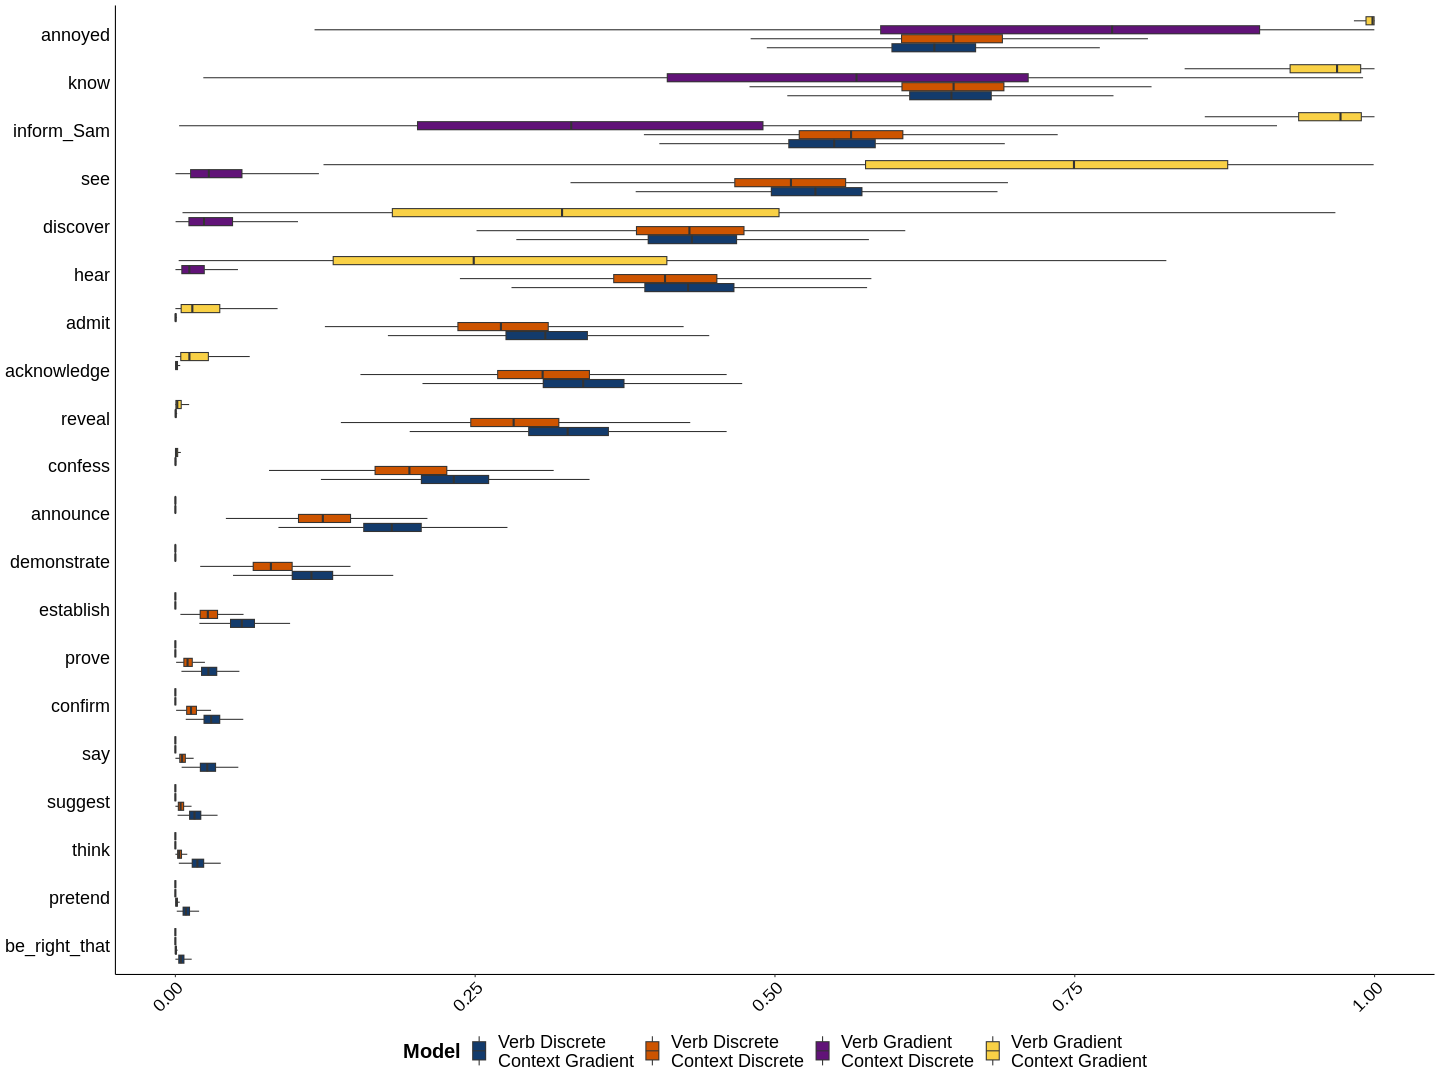

In [157]:
%%R -i verb_probs -w 20 -h 15 -u in

p <- ggplot(verb_probs, aes(x=fct_reorder(variable, value, .fun = median), y=value, fill=fct_reorder(model, value, .fun = max))) + 
geom_boxplot(outlier.color="white") +
coord_flip() +
scale_fill_manual(name="Model", values=c("#133B6C","#CD5400", "#611378", "#F9D146")) +
theme(axis.title.x=element_blank(),
      axis.title.y=element_blank(),
      axis.text=element_text(size=18, color="black"),
      axis.text.x=element_text(angle=45, hjust=1),
      axis.ticks.y=element_blank(),
      legend.title=element_text(size=20, face="bold"),
      legend.text=element_text(size=18),
      legend.position="bottom")

ggsave("projection-posterior-distributions-verb.png", width=20, height=15)

p

In [73]:
fully_discrete_projection_model_bleached = FullyDiscreteProjectionModel(
    fully_discrete_projection_model, use_context_prior=False
)
fully_discrete_projection_model_bleached.fit(
    data_projection_bleached, map_initialization=False, 
    iter_warmup=2_000, iter_sampling=2_000, seed=40392
)

17:58:05 - cmdstanpy - INFO - compiling stan file /home/jovyan/work/projective-content/models/projection-model/fully-discrete/fully-discrete-model.stan to exe file /home/jovyan/work/projective-content/models/projection-model/fully-discrete/fully-discrete-model


Model initialized with verb-specific priors derived from verb-specific posteriors from prior_model.
Writing STAN file to models/projection-model/fully-discrete/fully-discrete-model.stan...


17:58:17 - cmdstanpy - INFO - compiled model executable: /home/jovyan/work/projective-content/models/projection-model/fully-discrete/fully-discrete-model
17:58:17 - cmdstanpy - WARNING - Stan compiler has produced 3 warnings:
17:58:17 - cmdstanpy - WARNING - 
--- Translating Stan model to C++ code ---
bin/stanc  --o=/home/jovyan/work/projective-content/models/projection-model/fully-discrete/fully-discrete-model.hpp /home/jovyan/work/projective-content/models/projection-model/fully-discrete/fully-discrete-model.stan
Warning in '/home/jovyan/work/projective-content/models/projection-model/fully-discrete/fully-discrete-model.stan', line 29, column 2: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.33.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
Warning in '/home/jovyan/work/projective-content/models/projection-model/fully-discrete/fully-dis

Fitting model by sampling...


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

17:59:16 - cmdstanpy - INFO - CmdStan done processing.
17:59:16 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: Exception: Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/home/jovyan/work/projective-content/models/projection-model/fully-discrete/fully-discrete-model.stan', line 3, column 4 to line 5, column 52) (in '/home/jovyan/work/projective-content/models/projection-model/fully-discrete/fully-discrete-model.stan', line 12, column 4 to line 16, column 6) (in '/home/jovyan/work/projective-content/models/projection-model/fully-discrete/fully-discrete-model.stan', line 69, column 4 to line 71, column 6)
Consider re-running with show_console=True if the above output is unclear!


In [74]:
verb_discrete_projection_model_bleached = VerbDiscreteProjectionModel(
    verb_discrete_projection_model, use_context_prior=False
)
verb_discrete_projection_model_bleached.fit(
    data_projection_bleached, map_initialization=False, 
    iter_warmup=2_000, iter_sampling=2_000, seed=40392
)

17:59:44 - cmdstanpy - INFO - compiling stan file /home/jovyan/work/projective-content/models/projection-model/verb-discrete/verb-discrete-model.stan to exe file /home/jovyan/work/projective-content/models/projection-model/verb-discrete/verb-discrete-model


Model initialized with verb-specific priors derived from verb-specific posteriors from prior_model.
Writing STAN file to models/projection-model/verb-discrete/verb-discrete-model.stan...


17:59:55 - cmdstanpy - INFO - compiled model executable: /home/jovyan/work/projective-content/models/projection-model/verb-discrete/verb-discrete-model
17:59:55 - cmdstanpy - WARNING - Stan compiler has produced 3 warnings:
17:59:55 - cmdstanpy - WARNING - 
--- Translating Stan model to C++ code ---
bin/stanc  --o=/home/jovyan/work/projective-content/models/projection-model/verb-discrete/verb-discrete-model.hpp /home/jovyan/work/projective-content/models/projection-model/verb-discrete/verb-discrete-model.stan
Warning in '/home/jovyan/work/projective-content/models/projection-model/verb-discrete/verb-discrete-model.stan', line 25, column 2: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.33.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
Warning in '/home/jovyan/work/projective-content/models/projection-model/verb-discrete/verb-discrete-mode

Fitting model by sampling...


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:00:51 - cmdstanpy - INFO - CmdStan done processing.


In [75]:
context_discrete_projection_model_bleached = ContextDiscreteProjectionModel(
    context_discrete_projection_model, use_context_prior=False
)
context_discrete_projection_model_bleached.fit(
    data_projection_bleached, map_initialization=False, 
    iter_warmup=2_000, iter_sampling=2_000, seed=40392
)

18:00:55 - cmdstanpy - INFO - compiling stan file /home/jovyan/work/projective-content/models/projection-model/context-discrete/context-discrete-model.stan to exe file /home/jovyan/work/projective-content/models/projection-model/context-discrete/context-discrete-model


Model initialized with verb-specific priors derived from verb-specific posteriors from prior_model.
Writing STAN file to models/projection-model/context-discrete/context-discrete-model.stan...


18:01:07 - cmdstanpy - INFO - compiled model executable: /home/jovyan/work/projective-content/models/projection-model/context-discrete/context-discrete-model
18:01:07 - cmdstanpy - WARNING - Stan compiler has produced 3 warnings:
18:01:07 - cmdstanpy - WARNING - 
--- Translating Stan model to C++ code ---
bin/stanc  --o=/home/jovyan/work/projective-content/models/projection-model/context-discrete/context-discrete-model.hpp /home/jovyan/work/projective-content/models/projection-model/context-discrete/context-discrete-model.stan
Warning in '/home/jovyan/work/projective-content/models/projection-model/context-discrete/context-discrete-model.stan', line 25, column 2: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.33.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
Warning in '/home/jovyan/work/projective-content/models/projection-model/context-

Fitting model by sampling...


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:02:39 - cmdstanpy - INFO - CmdStan done processing.


In [76]:
fully_gradient_projection_model_bleached = FullyGradientProjectionModel(
    fully_gradient_projection_model, use_context_prior=False
)
fully_gradient_projection_model_bleached.fit(
    data_projection_bleached, map_initialization=False, 
    iter_warmup=2_000, iter_sampling=2_000, seed=40392
)

18:03:28 - cmdstanpy - INFO - compiling stan file /home/jovyan/work/projective-content/models/projection-model/fully-gradient/fully-gradient-model.stan to exe file /home/jovyan/work/projective-content/models/projection-model/fully-gradient/fully-gradient-model


Model initialized with verb-specific priors derived from verb-specific posteriors from prior_model.
Writing STAN file to models/projection-model/fully-gradient/fully-gradient-model.stan...


18:03:40 - cmdstanpy - INFO - compiled model executable: /home/jovyan/work/projective-content/models/projection-model/fully-gradient/fully-gradient-model
18:03:40 - cmdstanpy - WARNING - Stan compiler has produced 3 warnings:
18:03:40 - cmdstanpy - WARNING - 
--- Translating Stan model to C++ code ---
bin/stanc  --o=/home/jovyan/work/projective-content/models/projection-model/fully-gradient/fully-gradient-model.hpp /home/jovyan/work/projective-content/models/projection-model/fully-gradient/fully-gradient-model.stan
Warning in '/home/jovyan/work/projective-content/models/projection-model/fully-gradient/fully-gradient-model.stan', line 25, column 2: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.33.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
Warning in '/home/jovyan/work/projective-content/models/projection-model/fully-gradient/fully-gra

Fitting model by sampling...


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:04:20 - cmdstanpy - INFO - CmdStan done processing.


In [77]:
projection_model_bleached_comparison = arviz.compare({
    "Verb Discrete\nContext Discrete": fully_discrete_projection_model_bleached.model_fit,
    "Verb Discrete\nContext Gradient": verb_discrete_projection_model_bleached.model_fit,
    "Verb Gradient\nContext Discrete": context_discrete_projection_model_bleached.model_fit,
    "Verb Gradient\nContext Gradient": fully_gradient_projection_model_bleached.model_fit
}).reset_index()

projection_model_bleached_comparison

/opt/conda/lib/python3.10/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated

,index,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
0,Verb Discrete\nContext Gradient,0,332.845638,81.485908,0.000000,7.693773e-01,22.649044,0.000000,True,log
1,Verb Discrete\nContext Discrete,1,285.583058,58.592741,47.262580,1.387744e-12,19.401362,12.218257,True,log
2,Verb Gradient\nContext Gradient,2,259.635296,137.912607,73.210342,8.188340e-02,23.932306,17.639465,True,log
3,Verb Gradient\nContext Discrete,3,255.201006,135.404597,77.644632,1.487393e-01,22.263381,17.510312,True,log


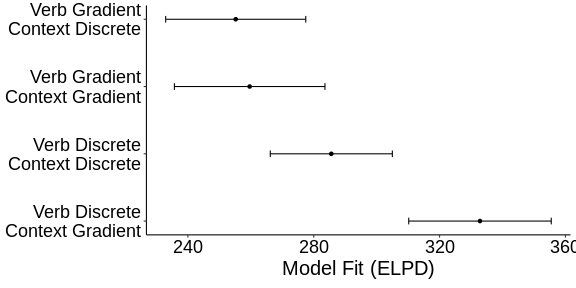

In [78]:
%%R -i projection_model_bleached_comparison -w 8 -h 4 -u in

p <- ggplot(projection_model_bleached_comparison, aes(x=rank, y=elpd_loo, ymin=elpd_loo-se, ymax=elpd_loo+se)) +
geom_errorbar(width=0.1) +
geom_point() +
scale_x_continuous(labels=projection_model_bleached_comparison$index) +
coord_flip() +
ylab(expression("Model Fit (ELPD)")) +
theme(axis.title.y=element_blank(),
      axis.title.x=element_text(size=20, face="bold"),
      axis.text=element_text(size=18, color="black"))

ggsave("projection_model_bleached_comparison.png", width=8, height=4)

p

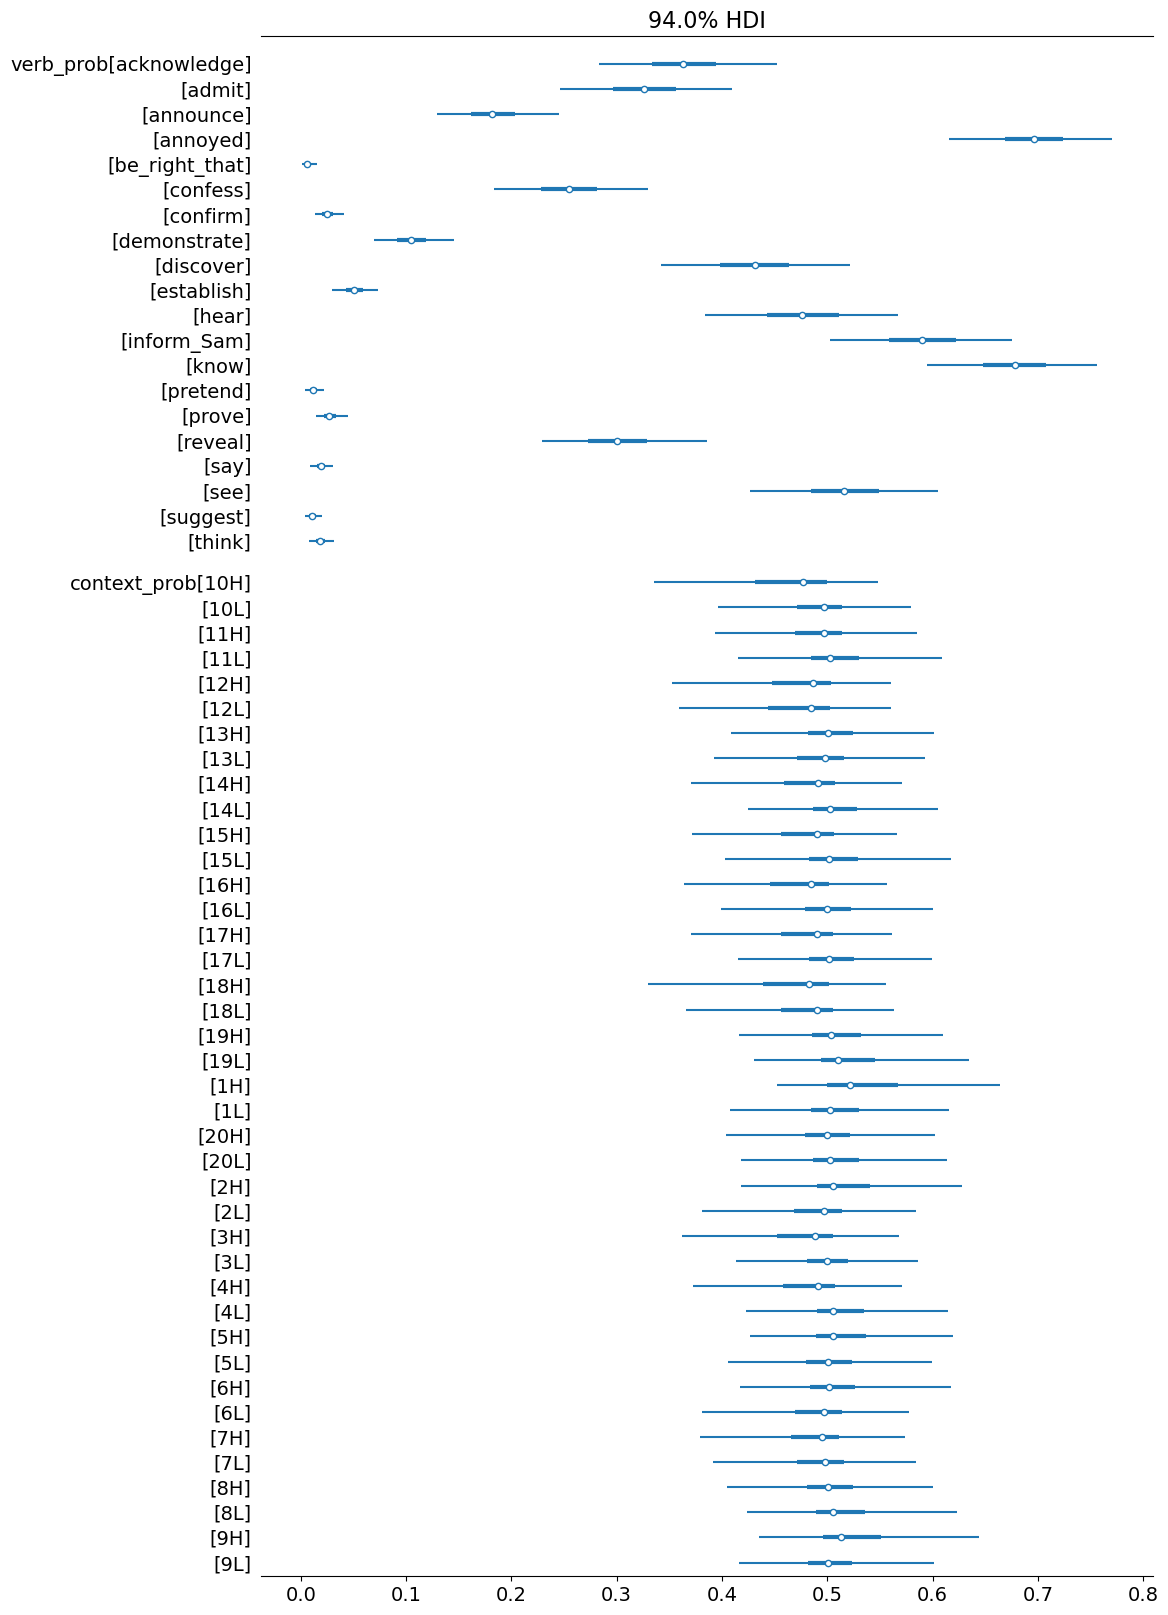

In [169]:
_ = arviz.plot_forest(
    verb_discrete_projection_model_bleached.model_fit,
    var_names=["verb_prob", "context_prob"],
    combined=True,
    figsize=(11.5, 20),
)

## Modeling the templatic data

In [80]:
fully_discrete_projection_model_templatic = FullyDiscreteProjectionModel(
    fully_discrete_projection_model, use_context_prior=False
)
fully_discrete_projection_model_templatic.fit(
    data_projection_templatic, map_initialization=False, 
    iter_warmup=2_000, iter_sampling=2_000, seed=40392
)

18:09:32 - cmdstanpy - INFO - compiling stan file /home/jovyan/work/projective-content/models/projection-model/fully-discrete/fully-discrete-model.stan to exe file /home/jovyan/work/projective-content/models/projection-model/fully-discrete/fully-discrete-model


Model initialized with verb-specific priors derived from verb-specific posteriors from prior_model.
Writing STAN file to models/projection-model/fully-discrete/fully-discrete-model.stan...


18:09:44 - cmdstanpy - INFO - compiled model executable: /home/jovyan/work/projective-content/models/projection-model/fully-discrete/fully-discrete-model
18:09:44 - cmdstanpy - WARNING - Stan compiler has produced 3 warnings:
18:09:44 - cmdstanpy - WARNING - 
--- Translating Stan model to C++ code ---
bin/stanc  --o=/home/jovyan/work/projective-content/models/projection-model/fully-discrete/fully-discrete-model.hpp /home/jovyan/work/projective-content/models/projection-model/fully-discrete/fully-discrete-model.stan
Warning in '/home/jovyan/work/projective-content/models/projection-model/fully-discrete/fully-discrete-model.stan', line 29, column 2: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.33.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
Warning in '/home/jovyan/work/projective-content/models/projection-model/fully-discrete/fully-dis

Fitting model by sampling...


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:10:36 - cmdstanpy - INFO - CmdStan done processing.


In [81]:
verb_discrete_projection_model_templatic = VerbDiscreteProjectionModel(
    verb_discrete_projection_model, use_context_prior=False
)
verb_discrete_projection_model_templatic.fit(
    data_projection_templatic, map_initialization=False, 
    iter_warmup=2_000, iter_sampling=2_000, seed=40392
)

18:10:37 - cmdstanpy - INFO - compiling stan file /home/jovyan/work/projective-content/models/projection-model/verb-discrete/verb-discrete-model.stan to exe file /home/jovyan/work/projective-content/models/projection-model/verb-discrete/verb-discrete-model


Model initialized with verb-specific priors derived from verb-specific posteriors from prior_model.
Writing STAN file to models/projection-model/verb-discrete/verb-discrete-model.stan...


18:10:49 - cmdstanpy - INFO - compiled model executable: /home/jovyan/work/projective-content/models/projection-model/verb-discrete/verb-discrete-model
18:10:49 - cmdstanpy - WARNING - Stan compiler has produced 3 warnings:
18:10:49 - cmdstanpy - WARNING - 
--- Translating Stan model to C++ code ---
bin/stanc  --o=/home/jovyan/work/projective-content/models/projection-model/verb-discrete/verb-discrete-model.hpp /home/jovyan/work/projective-content/models/projection-model/verb-discrete/verb-discrete-model.stan
Warning in '/home/jovyan/work/projective-content/models/projection-model/verb-discrete/verb-discrete-model.stan', line 25, column 2: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.33.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
Warning in '/home/jovyan/work/projective-content/models/projection-model/verb-discrete/verb-discrete-mode

Fitting model by sampling...


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:11:38 - cmdstanpy - INFO - CmdStan done processing.


In [82]:
context_discrete_projection_model_templatic = ContextDiscreteProjectionModel(
    context_discrete_projection_model, use_context_prior=False
)
context_discrete_projection_model_templatic.fit(
    data_projection_templatic, map_initialization=False, 
    iter_warmup=2_000, iter_sampling=2_000, seed=40392
)

18:11:39 - cmdstanpy - INFO - compiling stan file /home/jovyan/work/projective-content/models/projection-model/context-discrete/context-discrete-model.stan to exe file /home/jovyan/work/projective-content/models/projection-model/context-discrete/context-discrete-model


Model initialized with verb-specific priors derived from verb-specific posteriors from prior_model.
Writing STAN file to models/projection-model/context-discrete/context-discrete-model.stan...


18:11:51 - cmdstanpy - INFO - compiled model executable: /home/jovyan/work/projective-content/models/projection-model/context-discrete/context-discrete-model
18:11:51 - cmdstanpy - WARNING - Stan compiler has produced 3 warnings:
18:11:51 - cmdstanpy - WARNING - 
--- Translating Stan model to C++ code ---
bin/stanc  --o=/home/jovyan/work/projective-content/models/projection-model/context-discrete/context-discrete-model.hpp /home/jovyan/work/projective-content/models/projection-model/context-discrete/context-discrete-model.stan
Warning in '/home/jovyan/work/projective-content/models/projection-model/context-discrete/context-discrete-model.stan', line 25, column 2: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.33.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
Warning in '/home/jovyan/work/projective-content/models/projection-model/context-

Fitting model by sampling...


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:13:04 - cmdstanpy - INFO - CmdStan done processing.


In [83]:
fully_gradient_projection_model_templatic = FullyGradientProjectionModel(
    fully_gradient_projection_model, use_context_prior=False
)
fully_gradient_projection_model_templatic.fit(
    data_projection_templatic, map_initialization=False, 
    iter_warmup=2_000, iter_sampling=2_000, seed=40392
)

18:13:05 - cmdstanpy - INFO - compiling stan file /home/jovyan/work/projective-content/models/projection-model/fully-gradient/fully-gradient-model.stan to exe file /home/jovyan/work/projective-content/models/projection-model/fully-gradient/fully-gradient-model


Model initialized with verb-specific priors derived from verb-specific posteriors from prior_model.
Writing STAN file to models/projection-model/fully-gradient/fully-gradient-model.stan...


18:13:16 - cmdstanpy - INFO - compiled model executable: /home/jovyan/work/projective-content/models/projection-model/fully-gradient/fully-gradient-model
18:13:16 - cmdstanpy - WARNING - Stan compiler has produced 3 warnings:
18:13:16 - cmdstanpy - WARNING - 
--- Translating Stan model to C++ code ---
bin/stanc  --o=/home/jovyan/work/projective-content/models/projection-model/fully-gradient/fully-gradient-model.hpp /home/jovyan/work/projective-content/models/projection-model/fully-gradient/fully-gradient-model.stan
Warning in '/home/jovyan/work/projective-content/models/projection-model/fully-gradient/fully-gradient-model.stan', line 25, column 2: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.33.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
Warning in '/home/jovyan/work/projective-content/models/projection-model/fully-gradient/fully-gra

Fitting model by sampling...


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:13:53 - cmdstanpy - INFO - CmdStan done processing.


In [86]:
projection_model_templatic_comparison = arviz.compare({
    "Verb Discrete\nContext Discrete": fully_discrete_projection_model_templatic.model_fit,
    "Verb Discrete\nContext Gradient": verb_discrete_projection_model_templatic.model_fit,
    "Verb Gradient\nContext Discrete": context_discrete_projection_model_templatic.model_fit,
    "Verb Gradient\nContext Gradient": fully_gradient_projection_model_templatic.model_fit
}).reset_index()

projection_model_templatic_comparison

/opt/conda/lib/python3.10/site-packages/arviz/stats/stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/arviz/stats/stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/arviz/stats/stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/arviz/stats/stats.py:1645: UserWarning: For one or more samples the posterior variance of the

,index,rank,elpd_waic,p_waic,elpd_diff,weight,se,dse,warning,scale
0,Verb Discrete\nContext Gradient,0,346.285329,96.435562,0.000000,8.785926e-01,24.692399,0.000000,True,log
1,Verb Discrete\nContext Discrete,1,208.744150,47.504816,137.541179,6.583482e-13,15.411018,17.878901,True,log
2,Verb Gradient\nContext Discrete,2,203.044135,74.082380,143.241193,1.162812e-01,16.074514,19.303837,True,log
3,Verb Gradient\nContext Gradient,3,195.398499,107.716485,150.886830,5.126174e-03,20.570656,20.949281,True,log


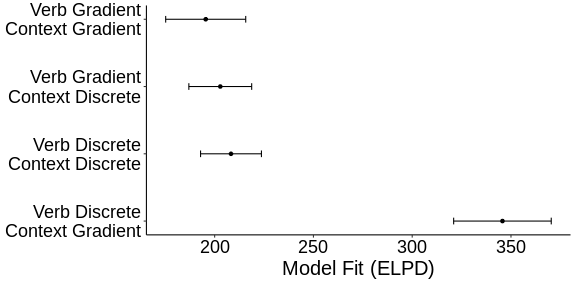

In [85]:
%%R -i projection_model_templatic_comparison -w 8 -h 4 -u in

p <- ggplot(projection_model_templatic_comparison, aes(x=rank, y=elpd_loo, ymin=elpd_loo-se, ymax=elpd_loo+se)) +
geom_errorbar(width=0.1) +
geom_point() +
scale_x_continuous(labels=projection_model_templatic_comparison$index) +
coord_flip() +
ylab(expression("Model Fit (ELPD)")) +
theme(axis.title.y=element_blank(),
      axis.title.x=element_text(size=20, face="bold"),
      axis.text=element_text(size=18, color="black"))

ggsave("projection_model_templatic_comparison.png", width=8, height=4)

p

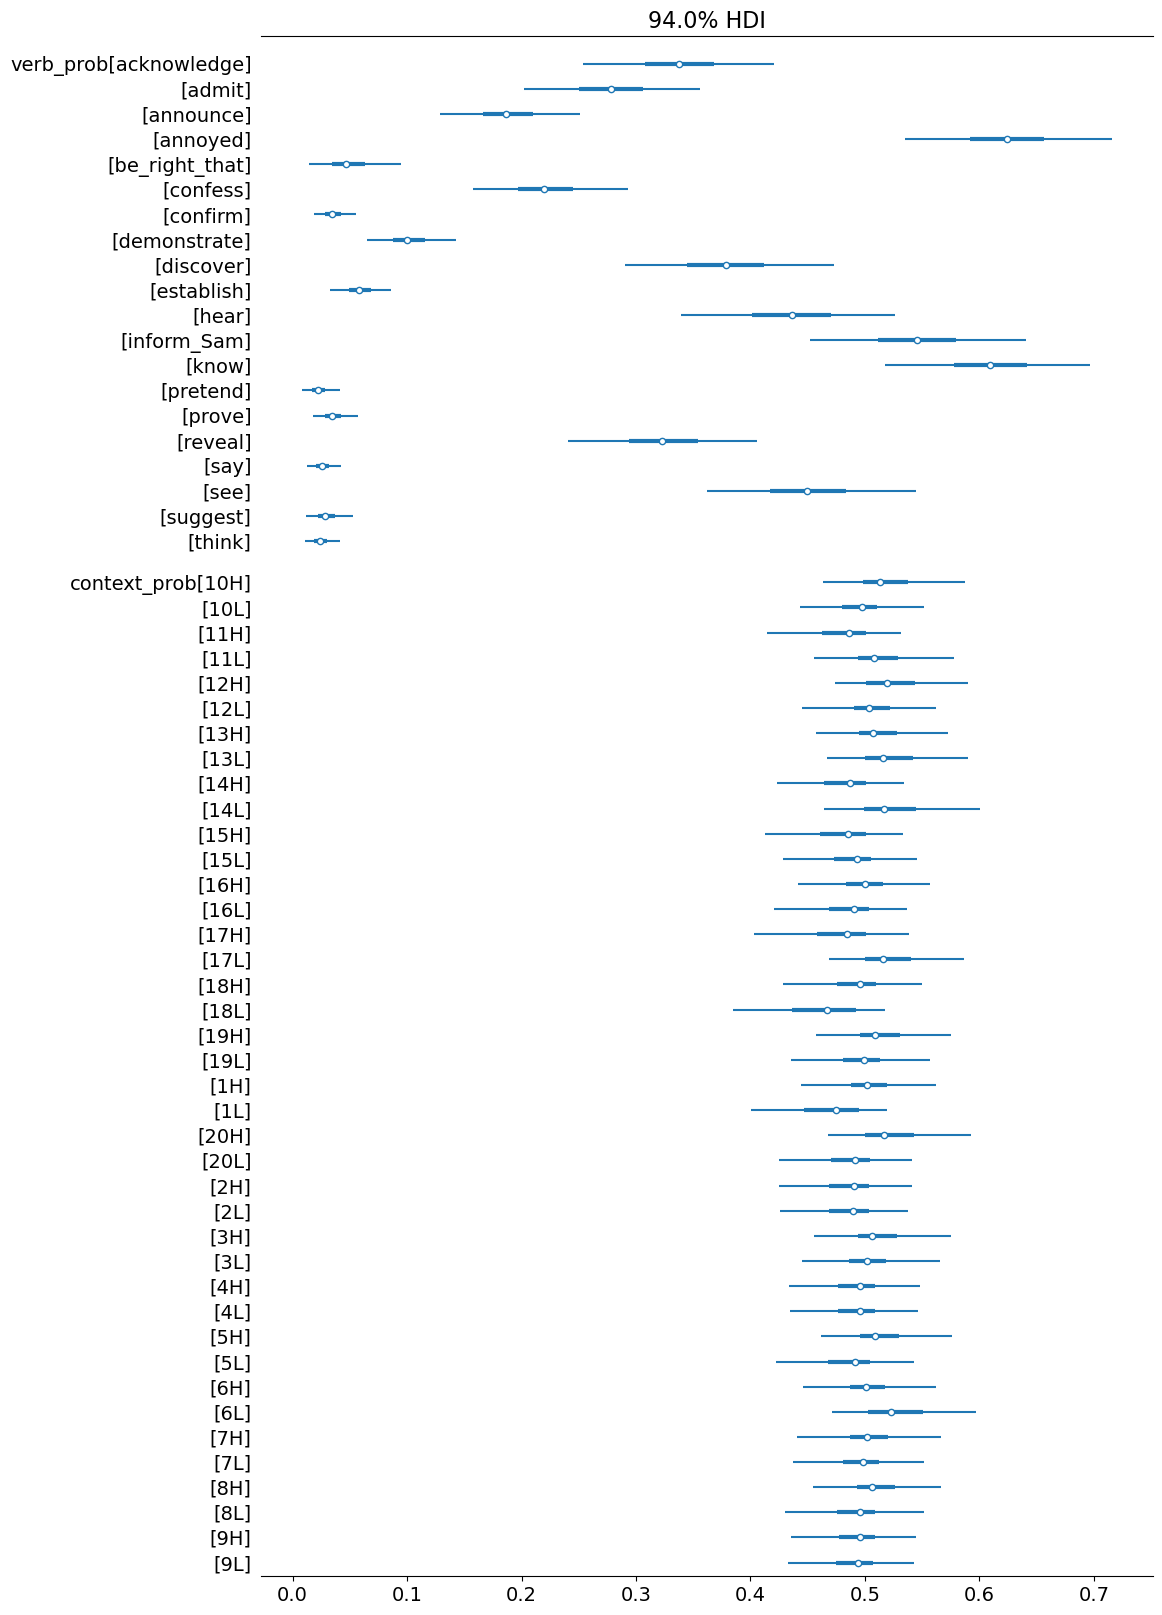

In [168]:
_ = arviz.plot_forest(
    verb_discrete_projection_model_templatic.model_fit,
    var_names=["verb_prob", "context_prob"],
    combined=True,
    figsize=(11.5, 20),
)